In [1]:
###########################################################
# This script tests a modified lenet5.
###########################################################

import numpy as np # linear algebra

import os
import glob

from matplotlib import cm
from matplotlib import pyplot as plt
import cv2
import util

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from torchvision import utils,models
import torch.nn.functional as F
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from PIL import Image
import PIL
from tqdm import trange
from time import sleep
from scipy.io import loadmat
import torchvision.datasets as dset
from torch.utils.data import sampler
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.multiprocessing as mp
import torch.distributed as dist
from partialconv2d import PartialConv2d

In [4]:
##Enable GPU
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [5]:
class EncodeBlock(nn.Module):
    def __init__(self, in_channel, out_channel, flag):
        super(EncodeBlock, self).__init__()
        self.conv = PartialConv2d(in_channel, out_channel, kernel_size = 3, padding = 1)
        #self.conv = nn.Conv2d(in_channel, out_channel, kernel_size = 3, padding = 1)
        self.nonlinear = nn.LeakyReLU(0.1)
        self.MaxPool = nn.MaxPool2d(2)
        self.flag = flag
        
    def forward(self, x, mask_in):
        out1, mask_out = self.conv(x, mask_in = mask_in)
        out2 = self.nonlinear(out1)
        if self.flag:
            out = self.MaxPool(out2)
            mask_out = self.MaxPool(mask_out)
        else:
            out = out2
        return out, mask_out

In [6]:
class DecodeBlock(nn.Module):
    def __init__(self, in_channel, mid_channel, out_channel, final_channel = 3, p = 0.7, flag = False):
        super(DecodeBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channel, mid_channel, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(mid_channel, out_channel, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(out_channel, final_channel, kernel_size = 3, padding = 1)
        self.nonlinear1 = nn.LeakyReLU(0.1)
        self.nonlinear2 = nn.LeakyReLU(0.1)
        self.sigmoid = nn.Sigmoid()
        self.flag = flag
        self.Dropout = nn.Dropout(p)
        
    def forward(self, x):
        out1 = self.conv1(self.Dropout(x))
        out2 = self.nonlinear1(out1)
        out3 = self.conv2(self.Dropout(out2))
        out4 = self.nonlinear2(out3)
        if self.flag:
            out5 = self.conv3(self.Dropout(out4))
            out = self.sigmoid(out5)
        else:
            out = out4
        return out

In [7]:
class self2self(nn.Module):
    def __init__(self, in_channel, p):
        super(self2self, self).__init__()
        self.EB0 = EncodeBlock(in_channel, 48, flag=False)
        self.EB1 = EncodeBlock(48, 48, flag=True)
        self.EB2 = EncodeBlock(48, 48, flag=True)
        self.EB3 = EncodeBlock(48, 48, flag=True)
        self.EB4 = EncodeBlock(48, 48, flag=True)
        self.EB5 = EncodeBlock(48, 48, flag=True)
        self.EB6 = EncodeBlock(48, 48, flag=False)
        
        self.DB1 = DecodeBlock(96, 96, 96,p=p)
        self.DB2 = DecodeBlock(144, 96, 96,p=p)
        self.DB3 = DecodeBlock(144, 96, 96,p=p)
        self.DB4 = DecodeBlock(144, 96, 96,p=p)
        self.DB5 = DecodeBlock(96+in_channel, 64, 32, in_channel,p=p, flag=True)
        
        self.Upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.concat_dim = 1
    def forward(self, x, mask):
        out_EB0, mask = self.EB0(x, mask)
        out_EB1, mask = self.EB1(out_EB0, mask)
        out_EB2, mask = self.EB2(out_EB1, mask_in = mask)
        out_EB3, mask = self.EB3(out_EB2, mask_in = mask)
        out_EB4, mask = self.EB4(out_EB3, mask_in = mask)
        out_EB5, mask = self.EB5(out_EB4, mask_in = mask)
        out_EB6, mask = self.EB6(out_EB5, mask_in = mask)
        
        out_EB6_up = self.Upsample(out_EB6)
        in_DB1 = torch.cat((out_EB6_up, out_EB4),self.concat_dim)
        out_DB1 = self.DB1((in_DB1))
        
        out_DB1_up = self.Upsample(out_DB1)
        in_DB2 = torch.cat((out_DB1_up, out_EB3),self.concat_dim)
        out_DB2 = self.DB2((in_DB2))
        
        out_DB2_up = self.Upsample(out_DB2)
        in_DB3 = torch.cat((out_DB2_up, out_EB2),self.concat_dim)
        out_DB3 = self.DB3((in_DB3))
        
        out_DB3_up = self.Upsample(out_DB3)
        in_DB4 = torch.cat((out_DB3_up, out_EB1),self.concat_dim)
        out_DB4 = self.DB4((in_DB4))
        
        out_DB4_up = self.Upsample(out_DB4)
        in_DB5 = torch.cat((out_DB4_up, x),self.concat_dim)
        out_DB5 = self.DB5(in_DB5)
        
        return out_DB5

In [8]:
def image_loader(image, device, p1, p2):
    """load image, returns cuda tensor"""
    loader = T.Compose([T.RandomHorizontalFlip(torch.round(torch.tensor(p1))),T.RandomVerticalFlip(torch.round(torch.tensor(p2))),T.ToTensor()])
    image = Image.fromarray(image.astype(np.uint8))
    image = loader(image).float()
    image = torch.tensor(image)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.to(device)

In [ ]:
model = self2self(3,0.3)
img = np.array(Image.open("5.png"))
learning_rate = 1e-4
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
w,h,c = img.shape
p=0.3
NPred=100
slice_avg = torch.tensor([1,3,512,512]).to(device)
for itr in range(500000):
    p_mtx = np.random.uniform(size=[img.shape[0],img.shape[1],img.shape[2]])
    mask = (p_mtx>p).astype(np.double)*0.7
    #img_input = img*mask
    img_input = img
    #y = img - img_input
    y = img
    p1 = np.random.uniform(size=1)
    p2 = np.random.uniform(size=1)
    img_input_tensor = image_loader(img_input, device, p1, p2)
    y = image_loader(y, device, p1, p2)
    mask = np.expand_dims(np.transpose(mask,[2,0,1]),0)
    mask = torch.tensor(mask).to(device, dtype=torch.float32)
    
    model.train()
    img_input_tensor = img_input_tensor*mask
    output = model(img_input_tensor, mask)
    
    loader = T.Compose([T.RandomHorizontalFlip(torch.round(torch.tensor(p1))),T.RandomVerticalFlip(torch.round(torch.tensor(p2)))])
    if itr == 0:
        slice_avg = loader(output)
    else:
        slice_avg = slice_avg*0.99+loader(output)*0.01
    #output = model(torch.mul(img_input_tensor,mask))
    #LossFunc = nn.MSELoss(reduction='sum')
    #loss = LossFunc(output*(mask), y*(mask))/torch.sum(mask)
    loss = torch.sum((output-y)*(output-y)*(1-mask))/torch.sum(1-mask)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(torch.max(output), torch.max(y))
    print("iteration %d, loss = %.4f" % (itr+1, loss.item()*100))
    #break
    if (itr+1)%1000 == 0:
        model.eval()
        sum_preds = np.zeros((img.shape[0],img.shape[1],img.shape[2]))
        for j in range(NPred):
            p_mtx = np.random.uniform(size=img.shape)
            mask = (p_mtx>p).astype(np.double)
            img_input = img*mask
            img_input_tensor = image_loader(img_input, device, 0.1, 0.1)
            mask = np.expand_dims(np.transpose(mask,[2,0,1]),0)
            mask = torch.tensor(mask).to(device, dtype=torch.float32)
            
            output_test = model(img_input_tensor,mask)
            sum_preds[:,:,:] += np.transpose(output_test.detach().cpu().numpy(),[2,3,1,0])[:,:,:,0]
        avg_preds = np.squeeze(np.uint8(np.clip((sum_preds-np.min(sum_preds)) / (np.max(sum_preds)-np.min(sum_preds)), 0, 1) * 255))
        #avg_preds = np.transpose(slice_avg.detach().cpu().numpy(),[2,3,1,0])[:,:,:,0]
        #avg_preds = np.squeeze(np.uint8(np.clip((avg_preds-np.min(avg_preds)) / (np.max(avg_preds)-np.min(avg_preds)), 0, 1) * 255))
        write_img = Image.fromarray(avg_preds)
        write_img.save("images/Self2self-"+str(itr+1)+".png")
        torch.save(model.state_dict(),'models/model-'+str(itr+1))
        #break

/home/yize/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


tensor(0.5304, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1, loss = 7.6996
tensor(0.5305, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2, loss = 7.6210
tensor(0.5292, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3, loss = 7.5600
tensor(0.5301, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4, loss = 7.5087
tensor(0.5311, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5, loss = 7.4582
tensor(0.5323, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6, loss = 7.3860
tensor(0.5344, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7, loss = 7.3259
tensor(0.5372, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8, loss = 7.2421
tensor(0.5404, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='c

tensor(0.9384, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 72, loss = 2.0071
tensor(0.9309, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 73, loss = 1.9965
tensor(0.9603, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 74, loss = 1.9805
tensor(0.9290, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 75, loss = 1.9590
tensor(0.9349, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 76, loss = 1.9332
tensor(0.9394, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 77, loss = 1.9215
tensor(0.9467, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 78, loss = 1.9108
tensor(0.9476, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 79, loss = 1.8653
tensor(0.9416, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, d

tensor(0.9867, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 143, loss = 0.7448
tensor(0.9807, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 144, loss = 0.7392
tensor(0.9745, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 145, loss = 0.7396
tensor(0.9721, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 146, loss = 0.7321
tensor(0.9706, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 147, loss = 0.7357
tensor(0.9754, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 148, loss = 0.7227
tensor(0.9763, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 149, loss = 0.7255
tensor(0.9759, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 150, loss = 0.7235
tensor(0.9738, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0

tensor(0.9663, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 214, loss = 0.5994
tensor(0.9599, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 215, loss = 0.5840
tensor(0.9603, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 216, loss = 0.5966
tensor(0.9760, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 217, loss = 0.5839
tensor(0.9616, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 218, loss = 0.5820
tensor(0.9687, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 219, loss = 0.5829
tensor(0.9660, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 220, loss = 0.5850
tensor(0.9688, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 221, loss = 0.5752
tensor(0.9609, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0

tensor(0.9608, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 285, loss = 0.5097
tensor(0.9603, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 286, loss = 0.5135
tensor(0.9630, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 287, loss = 0.5072
tensor(0.9615, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 288, loss = 0.5006
tensor(0.9591, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 289, loss = 0.5010
tensor(0.9566, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 290, loss = 0.5046
tensor(0.9628, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 291, loss = 0.5146
tensor(0.9576, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 292, loss = 0.5081
tensor(0.9605, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0

tensor(0.9567, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 356, loss = 0.4301
tensor(0.9523, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 357, loss = 0.4255
tensor(0.9543, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 358, loss = 0.4229
tensor(0.9525, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 359, loss = 0.4240
tensor(0.9543, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 360, loss = 0.4224
tensor(0.9551, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 361, loss = 0.4252
tensor(0.9490, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 362, loss = 0.4188
tensor(0.9540, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 363, loss = 0.4223
tensor(0.9563, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0

tensor(0.9552, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 427, loss = 0.3690
tensor(0.9555, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 428, loss = 0.3634
tensor(0.9511, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 429, loss = 0.3653
tensor(0.9511, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 430, loss = 0.3651
tensor(0.9536, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 431, loss = 0.3620
tensor(0.9605, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 432, loss = 0.3630
tensor(0.9566, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 433, loss = 0.3663
tensor(0.9610, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 434, loss = 0.3606
tensor(0.9523, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0

tensor(0.9525, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 498, loss = 0.3233
tensor(0.9475, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 499, loss = 0.3349
tensor(0.9481, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 500, loss = 0.3194
tensor(0.9481, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 501, loss = 0.3167
tensor(0.9560, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 502, loss = 0.3222
tensor(0.9563, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 503, loss = 0.3180
tensor(0.9566, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 504, loss = 0.3217
tensor(0.9494, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 505, loss = 0.3200
tensor(0.9536, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0

tensor(0.9480, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 569, loss = 0.2985
tensor(0.9437, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 570, loss = 0.3002
tensor(0.9568, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 571, loss = 0.2915
tensor(0.9560, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 572, loss = 0.2972
tensor(0.9443, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 573, loss = 0.2992
tensor(0.9539, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 574, loss = 0.2961
tensor(0.9447, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 575, loss = 0.2971
tensor(0.9501, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 576, loss = 0.2998
tensor(0.9534, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0

tensor(0.9533, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 640, loss = 0.2764
tensor(0.9444, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 641, loss = 0.2752
tensor(0.9493, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 642, loss = 0.2755
tensor(0.9464, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 643, loss = 0.2738
tensor(0.9576, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 644, loss = 0.2769
tensor(0.9446, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 645, loss = 0.2711
tensor(0.9492, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 646, loss = 0.2758
tensor(0.9548, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 647, loss = 0.2693
tensor(0.9482, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0

tensor(0.9440, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 711, loss = 0.2656
tensor(0.9475, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 712, loss = 0.2664
tensor(0.9529, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 713, loss = 0.2656
tensor(0.9453, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 714, loss = 0.2616
tensor(0.9427, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 715, loss = 0.2641
tensor(0.9438, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 716, loss = 0.2578
tensor(0.9494, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 717, loss = 0.2663
tensor(0.9481, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 718, loss = 0.2632
tensor(0.9573, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0

tensor(0.9521, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 782, loss = 0.2589
tensor(0.9544, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 783, loss = 0.2586
tensor(0.9431, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 784, loss = 0.2555
tensor(0.9388, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 785, loss = 0.2518
tensor(0.9520, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 786, loss = 0.2557
tensor(0.9516, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 787, loss = 0.2618
tensor(0.9407, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 788, loss = 0.2463
tensor(0.9417, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 789, loss = 0.2511
tensor(0.9486, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0

tensor(0.9469, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 853, loss = 0.2413
tensor(0.9440, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 854, loss = 0.2423
tensor(0.9520, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 855, loss = 0.2426
tensor(0.9481, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 856, loss = 0.2416
tensor(0.9456, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 857, loss = 0.2438
tensor(0.9475, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 858, loss = 0.2388
tensor(0.9503, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 859, loss = 0.2419
tensor(0.9377, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 860, loss = 0.2414
tensor(0.9516, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0

tensor(0.9491, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 924, loss = 0.2314
tensor(0.9430, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 925, loss = 0.2326
tensor(0.9520, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 926, loss = 0.2337
tensor(0.9510, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 927, loss = 0.2436
tensor(0.9485, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 928, loss = 0.2240
tensor(0.9511, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 929, loss = 0.2293
tensor(0.9497, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 930, loss = 0.2347
tensor(0.9525, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 931, loss = 0.2332
tensor(0.9424, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0

tensor(0.9555, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 995, loss = 0.2331
tensor(0.9519, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 996, loss = 0.2232
tensor(0.9408, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 997, loss = 0.2215
tensor(0.9582, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 998, loss = 0.2261
tensor(0.9462, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 999, loss = 0.2230
tensor(0.9541, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1000, loss = 0.2301
tensor(0.9508, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1001, loss = 0.2169
tensor(0.9554, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1002, loss = 0.2300
tensor(0.9488, device='cuda:0', grad_fn=<MaxBackward1>) tenso

tensor(0.9422, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1065, loss = 0.2123
tensor(0.9660, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1066, loss = 0.2161
tensor(0.9532, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1067, loss = 0.2226
tensor(0.9561, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1068, loss = 0.2207
tensor(0.9626, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1069, loss = 0.2216
tensor(0.9610, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1070, loss = 0.2289
tensor(0.9515, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1071, loss = 0.2127
tensor(0.9607, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1072, loss = 0.2237
tensor(0.9602, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9636, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1135, loss = 0.2187
tensor(0.9539, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1136, loss = 0.2172
tensor(0.9615, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1137, loss = 0.2129
tensor(0.9505, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1138, loss = 0.2159
tensor(0.9541, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1139, loss = 0.2145
tensor(0.9555, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1140, loss = 0.2162
tensor(0.9569, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1141, loss = 0.1993
tensor(0.9623, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1142, loss = 0.2113
tensor(0.9464, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9675, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1205, loss = 0.2160
tensor(0.9667, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1206, loss = 0.2134
tensor(0.9548, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1207, loss = 0.2047
tensor(0.9480, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1208, loss = 0.1925
tensor(0.9577, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1209, loss = 0.2053
tensor(0.9590, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1210, loss = 0.2050
tensor(0.9608, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1211, loss = 0.2113
tensor(0.9468, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1212, loss = 0.1970
tensor(0.9473, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9591, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1275, loss = 0.1843
tensor(0.9537, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1276, loss = 0.1827
tensor(0.9609, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1277, loss = 0.2016
tensor(0.9548, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1278, loss = 0.1991
tensor(0.9631, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1279, loss = 0.2048
tensor(0.9579, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1280, loss = 0.1862
tensor(0.9646, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1281, loss = 0.2073
tensor(0.9607, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1282, loss = 0.1987
tensor(0.9600, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9501, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1345, loss = 0.1858
tensor(0.9623, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1346, loss = 0.1757
tensor(0.9532, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1347, loss = 0.1860
tensor(0.9506, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1348, loss = 0.1851
tensor(0.9584, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1349, loss = 0.1992
tensor(0.9596, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1350, loss = 0.1842
tensor(0.9624, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1351, loss = 0.2011
tensor(0.9549, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1352, loss = 0.1752
tensor(0.9602, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9497, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1415, loss = 0.1733
tensor(0.9595, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1416, loss = 0.1908
tensor(0.9494, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1417, loss = 0.1996
tensor(0.9590, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1418, loss = 0.1985
tensor(0.9616, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1419, loss = 0.1986
tensor(0.9544, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1420, loss = 0.1721
tensor(0.9577, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1421, loss = 0.1772
tensor(0.9512, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1422, loss = 0.1756
tensor(0.9515, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9498, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1485, loss = 0.1637
tensor(0.9696, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1486, loss = 0.1634
tensor(0.9493, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1487, loss = 0.1639
tensor(0.9530, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1488, loss = 0.1804
tensor(0.9515, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1489, loss = 0.1721
tensor(0.9655, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1490, loss = 0.1905
tensor(0.9578, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1491, loss = 0.1961
tensor(0.9551, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1492, loss = 0.1836
tensor(0.9597, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9620, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1555, loss = 0.1646
tensor(0.9737, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1556, loss = 0.1595
tensor(0.9534, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1557, loss = 0.1812
tensor(0.9554, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1558, loss = 0.1583
tensor(0.9533, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1559, loss = 0.1624
tensor(0.9597, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1560, loss = 0.1618
tensor(0.9624, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1561, loss = 0.1641
tensor(0.9552, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1562, loss = 0.1640
tensor(0.9529, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9552, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1625, loss = 0.1585
tensor(0.9744, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1626, loss = 0.1581
tensor(0.9493, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1627, loss = 0.1783
tensor(0.9614, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1628, loss = 0.1779
tensor(0.9599, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1629, loss = 0.1562
tensor(0.9503, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1630, loss = 0.1604
tensor(0.9572, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1631, loss = 0.1589
tensor(0.9553, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1632, loss = 0.1558
tensor(0.9546, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9591, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1695, loss = 0.1549
tensor(0.9610, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1696, loss = 0.1553
tensor(0.9625, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1697, loss = 0.1530
tensor(0.9477, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1698, loss = 0.1773
tensor(0.9612, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1699, loss = 0.1531
tensor(0.9663, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1700, loss = 0.1740
tensor(0.9597, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1701, loss = 0.1551
tensor(0.9603, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1702, loss = 0.1744
tensor(0.9578, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9602, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1765, loss = 0.1499
tensor(0.9576, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1766, loss = 0.1737
tensor(0.9629, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1767, loss = 0.1730
tensor(0.9541, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1768, loss = 0.1716
tensor(0.9594, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1769, loss = 0.1498
tensor(0.9563, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1770, loss = 0.1493
tensor(0.9624, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1771, loss = 0.1703
tensor(0.9547, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1772, loss = 0.1508
tensor(0.9637, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9579, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1835, loss = 0.1472
tensor(0.9629, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1836, loss = 0.1476
tensor(0.9636, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1837, loss = 0.1466
tensor(0.9497, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1838, loss = 0.1658
tensor(0.9587, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1839, loss = 0.1458
tensor(0.9514, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1840, loss = 0.1671
tensor(0.9648, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1841, loss = 0.1439
tensor(0.9531, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1842, loss = 0.1652
tensor(0.9659, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9719, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1905, loss = 0.1618
tensor(0.9559, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1906, loss = 0.1631
tensor(0.9458, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1907, loss = 0.1624
tensor(0.9541, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1908, loss = 0.1449
tensor(0.9673, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1909, loss = 0.1615
tensor(0.9533, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1910, loss = 0.1637
tensor(0.9562, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1911, loss = 0.1429
tensor(0.9639, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1912, loss = 0.1453
tensor(0.9571, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9515, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1975, loss = 0.1540
tensor(0.9571, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1976, loss = 0.1559
tensor(0.9597, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1977, loss = 0.1548
tensor(0.9600, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1978, loss = 0.1428
tensor(0.9542, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1979, loss = 0.1416
tensor(0.9698, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1980, loss = 0.1433
tensor(0.9641, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1981, loss = 0.1568
tensor(0.9526, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 1982, loss = 0.1427
tensor(0.9614, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9647, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2045, loss = 0.1522
tensor(0.9625, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2046, loss = 0.1409
tensor(0.9683, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2047, loss = 0.1522
tensor(0.9504, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2048, loss = 0.1505
tensor(0.9647, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2049, loss = 0.1396
tensor(0.9542, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2050, loss = 0.1509
tensor(0.9674, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2051, loss = 0.1383
tensor(0.9616, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2052, loss = 0.1513
tensor(0.9576, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9581, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2115, loss = 0.1385
tensor(0.9597, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2116, loss = 0.1492
tensor(0.9674, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2117, loss = 0.1383
tensor(0.9647, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2118, loss = 0.1373
tensor(0.9658, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2119, loss = 0.1522
tensor(0.9667, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2120, loss = 0.1486
tensor(0.9631, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2121, loss = 0.1503
tensor(0.9565, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2122, loss = 0.1486
tensor(0.9560, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9716, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2185, loss = 0.1440
tensor(0.9665, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2186, loss = 0.1425
tensor(0.9554, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2187, loss = 0.1429
tensor(0.9635, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2188, loss = 0.1436
tensor(0.9648, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2189, loss = 0.1440
tensor(0.9509, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2190, loss = 0.1365
tensor(0.9731, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2191, loss = 0.1438
tensor(0.9653, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2192, loss = 0.1340
tensor(0.9570, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9696, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2255, loss = 0.1379
tensor(0.9476, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2256, loss = 0.1338
tensor(0.9554, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2257, loss = 0.1386
tensor(0.9605, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2258, loss = 0.1324
tensor(0.9668, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2259, loss = 0.1391
tensor(0.9563, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2260, loss = 0.1343
tensor(0.9541, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2261, loss = 0.1341
tensor(0.9711, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2262, loss = 0.1390
tensor(0.9616, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9614, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2325, loss = 0.1331
tensor(0.9711, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2326, loss = 0.1382
tensor(0.9734, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2327, loss = 0.1343
tensor(0.9643, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2328, loss = 0.1357
tensor(0.9591, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2329, loss = 0.1317
tensor(0.9578, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2330, loss = 0.1297
tensor(0.9502, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2331, loss = 0.1321
tensor(0.9461, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2332, loss = 0.1332
tensor(0.9606, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9713, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2395, loss = 0.1322
tensor(0.9563, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2396, loss = 0.1291
tensor(0.9605, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2397, loss = 0.1310
tensor(0.9536, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2398, loss = 0.1300
tensor(0.9511, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2399, loss = 0.1297
tensor(0.9631, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2400, loss = 0.1303
tensor(0.9506, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2401, loss = 0.1302
tensor(0.9533, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2402, loss = 0.1274
tensor(0.9721, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9694, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2465, loss = 0.1272
tensor(0.9624, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2466, loss = 0.1300
tensor(0.9536, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2467, loss = 0.1278
tensor(0.9616, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2468, loss = 0.1286
tensor(0.9642, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2469, loss = 0.1293
tensor(0.9770, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2470, loss = 0.1297
tensor(0.9607, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2471, loss = 0.1321
tensor(0.9519, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2472, loss = 0.1276
tensor(0.9561, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9687, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2535, loss = 0.1277
tensor(0.9521, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2536, loss = 0.1288
tensor(0.9604, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2537, loss = 0.1272
tensor(0.9680, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2538, loss = 0.1268
tensor(0.9573, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2539, loss = 0.1266
tensor(0.9673, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2540, loss = 0.1267
tensor(0.9672, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2541, loss = 0.1283
tensor(0.9494, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2542, loss = 0.1259
tensor(0.9417, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9597, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2605, loss = 0.1268
tensor(0.9720, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2606, loss = 0.1239
tensor(0.9514, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2607, loss = 0.1245
tensor(0.9630, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2608, loss = 0.1252
tensor(0.9588, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2609, loss = 0.1246
tensor(0.9548, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2610, loss = 0.1246
tensor(0.9578, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2611, loss = 0.1243
tensor(0.9493, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2612, loss = 0.1245
tensor(0.9478, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9613, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2675, loss = 0.1228
tensor(0.9616, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2676, loss = 0.1245
tensor(0.9760, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2677, loss = 0.1242
tensor(0.9656, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2678, loss = 0.1247
tensor(0.9599, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2679, loss = 0.1215
tensor(0.9497, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2680, loss = 0.1242
tensor(0.9546, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2681, loss = 0.1230
tensor(0.9678, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2682, loss = 0.1231
tensor(0.9635, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9597, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2745, loss = 0.1221
tensor(0.9554, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2746, loss = 0.1225
tensor(0.9395, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2747, loss = 0.1199
tensor(0.9588, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2748, loss = 0.1222
tensor(0.9613, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2749, loss = 0.1214
tensor(0.9605, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2750, loss = 0.1227
tensor(0.9802, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2751, loss = 0.1222
tensor(0.9603, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2752, loss = 0.1198
tensor(0.9526, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9514, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2815, loss = 0.1197
tensor(0.9453, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2816, loss = 0.1179
tensor(0.9668, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2817, loss = 0.1191
tensor(0.9686, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2818, loss = 0.1197
tensor(0.9597, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2819, loss = 0.1195
tensor(0.9688, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2820, loss = 0.1200
tensor(0.9643, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2821, loss = 0.1195
tensor(0.9678, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2822, loss = 0.1189
tensor(0.9538, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9648, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2885, loss = 0.1184
tensor(0.9613, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2886, loss = 0.1187
tensor(0.9559, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2887, loss = 0.1191
tensor(0.9629, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2888, loss = 0.1209
tensor(0.9601, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2889, loss = 0.1180
tensor(0.9761, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2890, loss = 0.1181
tensor(0.9709, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2891, loss = 0.1182
tensor(0.9468, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2892, loss = 0.1171
tensor(0.9722, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9598, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2955, loss = 0.1162
tensor(0.9643, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2956, loss = 0.1191
tensor(0.9470, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2957, loss = 0.1166
tensor(0.9621, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2958, loss = 0.1168
tensor(0.9449, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2959, loss = 0.1166
tensor(0.9652, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2960, loss = 0.1192
tensor(0.9709, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2961, loss = 0.1178
tensor(0.9614, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 2962, loss = 0.1163
tensor(0.9597, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9651, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3025, loss = 0.1156
tensor(0.9653, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3026, loss = 0.1168
tensor(0.9738, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3027, loss = 0.1156
tensor(0.9527, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3028, loss = 0.1152
tensor(0.9663, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3029, loss = 0.1187
tensor(0.9469, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3030, loss = 0.1163
tensor(0.9628, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3031, loss = 0.1152
tensor(0.9667, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3032, loss = 0.1172
tensor(0.9669, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9575, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3095, loss = 0.1142
tensor(0.9653, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3096, loss = 0.1159
tensor(0.9548, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3097, loss = 0.1149
tensor(0.9600, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3098, loss = 0.1124
tensor(0.9739, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3099, loss = 0.1158
tensor(0.9650, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3100, loss = 0.1156
tensor(0.9657, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3101, loss = 0.1149
tensor(0.9654, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3102, loss = 0.1174
tensor(0.9662, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9510, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3165, loss = 0.1135
tensor(0.9617, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3166, loss = 0.1153
tensor(0.9517, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3167, loss = 0.1143
tensor(0.9680, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3168, loss = 0.1146
tensor(0.9545, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3169, loss = 0.1151
tensor(0.9639, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3170, loss = 0.1139
tensor(0.9639, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3171, loss = 0.1134
tensor(0.9615, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3172, loss = 0.1145
tensor(0.9663, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9619, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3235, loss = 0.1137
tensor(0.9557, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3236, loss = 0.1109
tensor(0.9625, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3237, loss = 0.1131
tensor(0.9526, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3238, loss = 0.1128
tensor(0.9644, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3239, loss = 0.1127
tensor(0.9571, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3240, loss = 0.1124
tensor(0.9727, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3241, loss = 0.1122
tensor(0.9530, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3242, loss = 0.1138
tensor(0.9629, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9469, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3305, loss = 0.1107
tensor(0.9776, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3306, loss = 0.1124
tensor(0.9638, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3307, loss = 0.1108
tensor(0.9651, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3308, loss = 0.1127
tensor(0.9606, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3309, loss = 0.1111
tensor(0.9722, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3310, loss = 0.1113
tensor(0.9647, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3311, loss = 0.1109
tensor(0.9545, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3312, loss = 0.1108
tensor(0.9499, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9517, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3375, loss = 0.1121
tensor(0.9460, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3376, loss = 0.1112
tensor(0.9671, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3377, loss = 0.1107
tensor(0.9663, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3378, loss = 0.1133
tensor(0.9709, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3379, loss = 0.1138
tensor(0.9441, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3380, loss = 0.1107
tensor(0.9477, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3381, loss = 0.1098
tensor(0.9542, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3382, loss = 0.1123
tensor(0.9465, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9653, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3445, loss = 0.1086
tensor(0.9536, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3446, loss = 0.1086
tensor(0.9427, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3447, loss = 0.1092
tensor(0.9600, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3448, loss = 0.1097
tensor(0.9540, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3449, loss = 0.1100
tensor(0.9580, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3450, loss = 0.1097
tensor(0.9721, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3451, loss = 0.1085
tensor(0.9531, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3452, loss = 0.1095
tensor(0.9718, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9675, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3515, loss = 0.1091
tensor(0.9534, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3516, loss = 0.1088
tensor(0.9536, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3517, loss = 0.1074
tensor(0.9573, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3518, loss = 0.1079
tensor(0.9585, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3519, loss = 0.1095
tensor(0.9572, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3520, loss = 0.1083
tensor(0.9567, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3521, loss = 0.1092
tensor(0.9617, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3522, loss = 0.1095
tensor(0.9576, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9638, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3585, loss = 0.1087
tensor(0.9491, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3586, loss = 0.1067
tensor(0.9614, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3587, loss = 0.1059
tensor(0.9603, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3588, loss = 0.1080
tensor(0.9581, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3589, loss = 0.1070
tensor(0.9714, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3590, loss = 0.1089
tensor(0.9429, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3591, loss = 0.1077
tensor(0.9459, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3592, loss = 0.1076
tensor(0.9605, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9659, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3655, loss = 0.1066
tensor(0.9649, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3656, loss = 0.1063
tensor(0.9663, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3657, loss = 0.1077
tensor(0.9613, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3658, loss = 0.1059
tensor(0.9459, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3659, loss = 0.1060
tensor(0.9456, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3660, loss = 0.1057
tensor(0.9734, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3661, loss = 0.1071
tensor(0.9627, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3662, loss = 0.1077
tensor(0.9566, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9579, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3725, loss = 0.1044
tensor(0.9712, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3726, loss = 0.1053
tensor(0.9669, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3727, loss = 0.1062
tensor(0.9635, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3728, loss = 0.1068
tensor(0.9669, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3729, loss = 0.1053
tensor(0.9428, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3730, loss = 0.1059
tensor(0.9695, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3731, loss = 0.1059
tensor(0.9486, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3732, loss = 0.1076
tensor(0.9526, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9488, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3795, loss = 0.1048
tensor(0.9502, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3796, loss = 0.1038
tensor(0.9691, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3797, loss = 0.1039
tensor(0.9566, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3798, loss = 0.1032
tensor(0.9499, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3799, loss = 0.1044
tensor(0.9530, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3800, loss = 0.1035
tensor(0.9597, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3801, loss = 0.1054
tensor(0.9605, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3802, loss = 0.1030
tensor(0.9535, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9711, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3865, loss = 0.1045
tensor(0.9619, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3866, loss = 0.1048
tensor(0.9648, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3867, loss = 0.1031
tensor(0.9478, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3868, loss = 0.1041
tensor(0.9655, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3869, loss = 0.1049
tensor(0.9648, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3870, loss = 0.1044
tensor(0.9543, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3871, loss = 0.1024
tensor(0.9556, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3872, loss = 0.1031
tensor(0.9785, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9531, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3935, loss = 0.1038
tensor(0.9685, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3936, loss = 0.1018
tensor(0.9620, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3937, loss = 0.1026
tensor(0.9464, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3938, loss = 0.1028
tensor(0.9660, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3939, loss = 0.1027
tensor(0.9483, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3940, loss = 0.1025
tensor(0.9600, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3941, loss = 0.1038
tensor(0.9605, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 3942, loss = 0.1031
tensor(0.9453, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9620, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4005, loss = 0.1041
tensor(0.9618, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4006, loss = 0.1025
tensor(0.9624, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4007, loss = 0.1019
tensor(0.9591, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4008, loss = 0.1008
tensor(0.9749, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4009, loss = 0.1020
tensor(0.9465, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4010, loss = 0.1022
tensor(0.9556, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4011, loss = 0.1019
tensor(0.9573, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4012, loss = 0.1008
tensor(0.9554, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9537, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4075, loss = 0.1014
tensor(0.9640, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4076, loss = 0.1017
tensor(0.9674, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4077, loss = 0.1009
tensor(0.9589, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4078, loss = 0.0998
tensor(0.9642, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4079, loss = 0.1012
tensor(0.9699, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4080, loss = 0.1030
tensor(0.9604, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4081, loss = 0.1005
tensor(0.9456, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4082, loss = 0.1034
tensor(0.9544, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9576, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4145, loss = 0.1011
tensor(0.9633, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4146, loss = 0.1020
tensor(0.9695, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4147, loss = 0.1023
tensor(0.9655, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4148, loss = 0.1023
tensor(0.9570, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4149, loss = 0.1005
tensor(0.9578, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4150, loss = 0.1008
tensor(0.9607, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4151, loss = 0.1004
tensor(0.9653, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4152, loss = 0.1022
tensor(0.9520, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9522, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4215, loss = 0.0997
tensor(0.9620, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4216, loss = 0.0991
tensor(0.9621, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4217, loss = 0.1019
tensor(0.9598, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4218, loss = 0.1017
tensor(0.9605, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4219, loss = 0.1000
tensor(0.9617, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4220, loss = 0.0988
tensor(0.9531, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4221, loss = 0.0999
tensor(0.9529, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4222, loss = 0.1004
tensor(0.9496, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9746, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4285, loss = 0.1000
tensor(0.9559, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4286, loss = 0.1000
tensor(0.9597, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4287, loss = 0.0991
tensor(0.9535, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4288, loss = 0.0991
tensor(0.9518, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4289, loss = 0.0993
tensor(0.9605, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4290, loss = 0.0998
tensor(0.9609, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4291, loss = 0.0999
tensor(0.9579, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4292, loss = 0.1001
tensor(0.9470, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9636, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4355, loss = 0.0972
tensor(0.9612, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4356, loss = 0.0974
tensor(0.9678, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4357, loss = 0.0982
tensor(0.9465, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4358, loss = 0.0984
tensor(0.9587, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4359, loss = 0.1010
tensor(0.9440, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4360, loss = 0.0987
tensor(0.9563, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4361, loss = 0.0966
tensor(0.9521, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4362, loss = 0.0983
tensor(0.9475, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9594, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4425, loss = 0.0968
tensor(0.9456, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4426, loss = 0.0968
tensor(0.9597, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4427, loss = 0.0992
tensor(0.9549, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4428, loss = 0.0996
tensor(0.9492, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4429, loss = 0.0972
tensor(0.9651, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4430, loss = 0.0983
tensor(0.9566, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4431, loss = 0.0975
tensor(0.9508, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4432, loss = 0.0978
tensor(0.9624, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9534, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4495, loss = 0.0970
tensor(0.9515, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4496, loss = 0.0955
tensor(0.9652, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4497, loss = 0.0982
tensor(0.9686, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4498, loss = 0.0976
tensor(0.9639, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4499, loss = 0.0968
tensor(0.9480, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4500, loss = 0.0976
tensor(0.9565, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4501, loss = 0.0979
tensor(0.9587, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4502, loss = 0.0978
tensor(0.9560, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9668, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4565, loss = 0.0963
tensor(0.9760, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4566, loss = 0.0954
tensor(0.9536, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4567, loss = 0.0964
tensor(0.9471, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4568, loss = 0.0960
tensor(0.9700, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4569, loss = 0.0955
tensor(0.9480, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4570, loss = 0.0959
tensor(0.9642, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4571, loss = 0.0972
tensor(0.9510, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4572, loss = 0.0960
tensor(0.9548, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9588, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4635, loss = 0.0954
tensor(0.9575, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4636, loss = 0.0961
tensor(0.9657, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4637, loss = 0.0959
tensor(0.9647, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4638, loss = 0.0955
tensor(0.9576, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4639, loss = 0.0956
tensor(0.9558, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4640, loss = 0.0954
tensor(0.9453, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4641, loss = 0.0958
tensor(0.9614, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4642, loss = 0.0965
tensor(0.9572, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9464, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4705, loss = 0.0950
tensor(0.9462, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4706, loss = 0.0936
tensor(0.9470, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4707, loss = 0.0944
tensor(0.9579, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4708, loss = 0.0955
tensor(0.9675, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4709, loss = 0.0954
tensor(0.9617, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4710, loss = 0.0953
tensor(0.9627, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4711, loss = 0.0961
tensor(0.9608, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4712, loss = 0.0992
tensor(0.9588, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9483, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4775, loss = 0.0950
tensor(0.9619, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4776, loss = 0.0939
tensor(0.9655, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4777, loss = 0.0948
tensor(0.9488, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4778, loss = 0.0940
tensor(0.9562, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4779, loss = 0.0939
tensor(0.9503, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4780, loss = 0.0948
tensor(0.9522, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4781, loss = 0.0956
tensor(0.9623, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4782, loss = 0.0942
tensor(0.9494, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9605, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4845, loss = 0.0954
tensor(0.9563, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4846, loss = 0.0947
tensor(0.9731, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4847, loss = 0.0940
tensor(0.9549, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4848, loss = 0.0942
tensor(0.9452, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4849, loss = 0.0951
tensor(0.9718, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4850, loss = 0.0948
tensor(0.9537, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4851, loss = 0.0946
tensor(0.9471, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4852, loss = 0.0932
tensor(0.9542, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9631, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4915, loss = 0.0919
tensor(0.9394, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4916, loss = 0.0932
tensor(0.9618, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4917, loss = 0.0925
tensor(0.9566, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4918, loss = 0.0929
tensor(0.9507, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4919, loss = 0.0944
tensor(0.9546, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4920, loss = 0.0937
tensor(0.9549, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4921, loss = 0.0940
tensor(0.9585, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4922, loss = 0.0935
tensor(0.9492, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9423, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4985, loss = 0.0935
tensor(0.9720, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4986, loss = 0.0930
tensor(0.9507, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4987, loss = 0.0936
tensor(0.9492, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4988, loss = 0.0930
tensor(0.9602, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4989, loss = 0.0932
tensor(0.9583, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4990, loss = 0.0953
tensor(0.9577, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4991, loss = 0.0940
tensor(0.9590, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 4992, loss = 0.0923
tensor(0.9666, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9555, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5055, loss = 0.0907
tensor(0.9491, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5056, loss = 0.0919
tensor(0.9635, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5057, loss = 0.0929
tensor(0.9584, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5058, loss = 0.0916
tensor(0.9695, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5059, loss = 0.0916
tensor(0.9472, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5060, loss = 0.0915
tensor(0.9555, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5061, loss = 0.0919
tensor(0.9460, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5062, loss = 0.0921
tensor(0.9538, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9669, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5125, loss = 0.0918
tensor(0.9446, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5126, loss = 0.0915
tensor(0.9708, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5127, loss = 0.0932
tensor(0.9502, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5128, loss = 0.0925
tensor(0.9627, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5129, loss = 0.0920
tensor(0.9529, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5130, loss = 0.0920
tensor(0.9537, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5131, loss = 0.0925
tensor(0.9517, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5132, loss = 0.0910
tensor(0.9546, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9534, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5195, loss = 0.0897
tensor(0.9575, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5196, loss = 0.0910
tensor(0.9663, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5197, loss = 0.0914
tensor(0.9484, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5198, loss = 0.0902
tensor(0.9510, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5199, loss = 0.0914
tensor(0.9592, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5200, loss = 0.0914
tensor(0.9523, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5201, loss = 0.0908
tensor(0.9434, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5202, loss = 0.0917
tensor(0.9459, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9510, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5265, loss = 0.0909
tensor(0.9565, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5266, loss = 0.0907
tensor(0.9573, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5267, loss = 0.0903
tensor(0.9584, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5268, loss = 0.0910
tensor(0.9468, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5269, loss = 0.0902
tensor(0.9525, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5270, loss = 0.0894
tensor(0.9559, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5271, loss = 0.0886
tensor(0.9456, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5272, loss = 0.0896
tensor(0.9519, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9502, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5335, loss = 0.0896
tensor(0.9603, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5336, loss = 0.0882
tensor(0.9506, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5337, loss = 0.0924
tensor(0.9528, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5338, loss = 0.0904
tensor(0.9511, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5339, loss = 0.0910
tensor(0.9544, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5340, loss = 0.0911
tensor(0.9582, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5341, loss = 0.0900
tensor(0.9581, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5342, loss = 0.0903
tensor(0.9500, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9341, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5405, loss = 0.0888
tensor(0.9558, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5406, loss = 0.0888
tensor(0.9760, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5407, loss = 0.0875
tensor(0.9578, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5408, loss = 0.0889
tensor(0.9502, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5409, loss = 0.0878
tensor(0.9530, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5410, loss = 0.0883
tensor(0.9510, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5411, loss = 0.0897
tensor(0.9443, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5412, loss = 0.0890
tensor(0.9527, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9564, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5475, loss = 0.0877
tensor(0.9544, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5476, loss = 0.0884
tensor(0.9481, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5477, loss = 0.0884
tensor(0.9544, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5478, loss = 0.0902
tensor(0.9503, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5479, loss = 0.0888
tensor(0.9531, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5480, loss = 0.0882
tensor(0.9519, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5481, loss = 0.0887
tensor(0.9550, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5482, loss = 0.0878
tensor(0.9496, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9538, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5545, loss = 0.0897
tensor(0.9442, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5546, loss = 0.0878
tensor(0.9527, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5547, loss = 0.0880
tensor(0.9507, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5548, loss = 0.0889
tensor(0.9566, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5549, loss = 0.0889
tensor(0.9507, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5550, loss = 0.0879
tensor(0.9477, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5551, loss = 0.0891
tensor(0.9604, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5552, loss = 0.0888
tensor(0.9541, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9575, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5615, loss = 0.0891
tensor(0.9525, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5616, loss = 0.0894
tensor(0.9558, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5617, loss = 0.0876
tensor(0.9544, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5618, loss = 0.0894
tensor(0.9553, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5619, loss = 0.0876
tensor(0.9424, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5620, loss = 0.0877
tensor(0.9412, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5621, loss = 0.0876
tensor(0.9460, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5622, loss = 0.0887
tensor(0.9483, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9592, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5685, loss = 0.0874
tensor(0.9552, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5686, loss = 0.0875
tensor(0.9575, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5687, loss = 0.0875
tensor(0.9433, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5688, loss = 0.0872
tensor(0.9470, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5689, loss = 0.0878
tensor(0.9458, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5690, loss = 0.0864
tensor(0.9643, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5691, loss = 0.0876
tensor(0.9538, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5692, loss = 0.0882
tensor(0.9507, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9527, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5755, loss = 0.0879
tensor(0.9540, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5756, loss = 0.0883
tensor(0.9593, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5757, loss = 0.0855
tensor(0.9426, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5758, loss = 0.0880
tensor(0.9355, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5759, loss = 0.0873
tensor(0.9634, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5760, loss = 0.0879
tensor(0.9493, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5761, loss = 0.0878
tensor(0.9398, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5762, loss = 0.0865
tensor(0.9539, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9464, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5825, loss = 0.0851
tensor(0.9495, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5826, loss = 0.0859
tensor(0.9691, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5827, loss = 0.0876
tensor(0.9459, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5828, loss = 0.0862
tensor(0.9511, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5829, loss = 0.0872
tensor(0.9554, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5830, loss = 0.0882
tensor(0.9547, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5831, loss = 0.0858
tensor(0.9517, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5832, loss = 0.0874
tensor(0.9522, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9692, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5895, loss = 0.0857
tensor(0.9535, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5896, loss = 0.0873
tensor(0.9521, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5897, loss = 0.0864
tensor(0.9601, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5898, loss = 0.0860
tensor(0.9557, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5899, loss = 0.0862
tensor(0.9621, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5900, loss = 0.0863
tensor(0.9442, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5901, loss = 0.0858
tensor(0.9540, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5902, loss = 0.0853
tensor(0.9590, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9367, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5965, loss = 0.0867
tensor(0.9580, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5966, loss = 0.0862
tensor(0.9521, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5967, loss = 0.0852
tensor(0.9418, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5968, loss = 0.0865
tensor(0.9463, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5969, loss = 0.0863
tensor(0.9661, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5970, loss = 0.0846
tensor(0.9536, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5971, loss = 0.0841
tensor(0.9584, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 5972, loss = 0.0870
tensor(0.9618, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9545, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6035, loss = 0.0837
tensor(0.9468, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6036, loss = 0.0863
tensor(0.9507, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6037, loss = 0.0859
tensor(0.9555, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6038, loss = 0.0855
tensor(0.9574, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6039, loss = 0.0856
tensor(0.9475, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6040, loss = 0.0856
tensor(0.9543, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6041, loss = 0.0835
tensor(0.9538, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6042, loss = 0.0843
tensor(0.9484, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9520, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6105, loss = 0.0857
tensor(0.9545, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6106, loss = 0.0845
tensor(0.9527, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6107, loss = 0.0858
tensor(0.9639, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6108, loss = 0.0849
tensor(0.9362, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6109, loss = 0.0856
tensor(0.9679, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6110, loss = 0.0854
tensor(0.9509, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6111, loss = 0.0832
tensor(0.9602, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6112, loss = 0.0852
tensor(0.9496, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9501, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6175, loss = 0.0842
tensor(0.9502, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6176, loss = 0.0834
tensor(0.9551, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6177, loss = 0.0851
tensor(0.9584, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6178, loss = 0.0853
tensor(0.9582, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6179, loss = 0.0834
tensor(0.9494, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6180, loss = 0.0837
tensor(0.9438, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6181, loss = 0.0832
tensor(0.9457, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6182, loss = 0.0844
tensor(0.9445, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9544, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6245, loss = 0.0838
tensor(0.9397, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6246, loss = 0.0834
tensor(0.9590, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6247, loss = 0.0848
tensor(0.9603, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6248, loss = 0.0844
tensor(0.9463, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6249, loss = 0.0840
tensor(0.9524, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6250, loss = 0.0843
tensor(0.9531, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6251, loss = 0.0842
tensor(0.9615, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6252, loss = 0.0846
tensor(0.9447, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9447, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6315, loss = 0.0838
tensor(0.9573, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6316, loss = 0.0831
tensor(0.9459, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6317, loss = 0.0842
tensor(0.9645, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6318, loss = 0.0847
tensor(0.9703, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6319, loss = 0.0855
tensor(0.9517, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6320, loss = 0.0854
tensor(0.9488, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6321, loss = 0.0849
tensor(0.9572, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6322, loss = 0.0839
tensor(0.9420, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9570, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6385, loss = 0.0823
tensor(0.9487, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6386, loss = 0.0833
tensor(0.9496, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6387, loss = 0.0844
tensor(0.9498, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6388, loss = 0.0839
tensor(0.9490, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6389, loss = 0.0832
tensor(0.9534, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6390, loss = 0.0844
tensor(0.9535, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6391, loss = 0.0851
tensor(0.9578, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6392, loss = 0.0824
tensor(0.9438, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9570, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6455, loss = 0.0821
tensor(0.9389, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6456, loss = 0.0844
tensor(0.9471, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6457, loss = 0.0832
tensor(0.9590, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6458, loss = 0.0835
tensor(0.9630, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6459, loss = 0.0831
tensor(0.9651, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6460, loss = 0.0813
tensor(0.9519, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6461, loss = 0.0824
tensor(0.9358, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6462, loss = 0.0836
tensor(0.9532, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9482, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6525, loss = 0.0820
tensor(0.9591, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6526, loss = 0.0824
tensor(0.9524, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6527, loss = 0.0826
tensor(0.9408, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6528, loss = 0.0814
tensor(0.9482, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6529, loss = 0.0819
tensor(0.9479, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6530, loss = 0.0821
tensor(0.9589, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6531, loss = 0.0820
tensor(0.9386, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6532, loss = 0.0813
tensor(0.9512, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9465, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6595, loss = 0.0817
tensor(0.9546, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6596, loss = 0.0824
tensor(0.9484, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6597, loss = 0.0817
tensor(0.9561, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6598, loss = 0.0819
tensor(0.9460, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6599, loss = 0.0828
tensor(0.9446, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6600, loss = 0.0809
tensor(0.9568, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6601, loss = 0.0818
tensor(0.9476, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6602, loss = 0.0807
tensor(0.9560, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9485, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6665, loss = 0.0821
tensor(0.9635, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6666, loss = 0.0821
tensor(0.9426, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6667, loss = 0.0828
tensor(0.9363, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6668, loss = 0.0822
tensor(0.9425, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6669, loss = 0.0819
tensor(0.9482, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6670, loss = 0.0823
tensor(0.9555, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6671, loss = 0.0820
tensor(0.9695, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6672, loss = 0.0810
tensor(0.9496, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9473, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6735, loss = 0.0806
tensor(0.9591, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6736, loss = 0.0824
tensor(0.9464, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6737, loss = 0.0816
tensor(0.9474, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6738, loss = 0.0811
tensor(0.9418, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6739, loss = 0.0813
tensor(0.9568, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6740, loss = 0.0818
tensor(0.9533, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6741, loss = 0.0813
tensor(0.9426, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6742, loss = 0.0802
tensor(0.9524, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9464, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6805, loss = 0.0803
tensor(0.9531, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6806, loss = 0.0819
tensor(0.9526, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6807, loss = 0.0803
tensor(0.9597, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6808, loss = 0.0812
tensor(0.9488, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6809, loss = 0.0815
tensor(0.9511, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6810, loss = 0.0817
tensor(0.9622, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6811, loss = 0.0812
tensor(0.9535, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6812, loss = 0.0804
tensor(0.9483, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9513, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6875, loss = 0.0800
tensor(0.9502, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6876, loss = 0.0804
tensor(0.9344, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6877, loss = 0.0801
tensor(0.9537, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6878, loss = 0.0814
tensor(0.9622, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6879, loss = 0.0796
tensor(0.9515, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6880, loss = 0.0800
tensor(0.9693, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6881, loss = 0.0812
tensor(0.9546, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6882, loss = 0.0810
tensor(0.9429, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9425, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6945, loss = 0.0807
tensor(0.9548, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6946, loss = 0.0802
tensor(0.9567, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6947, loss = 0.0809
tensor(0.9478, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6948, loss = 0.0809
tensor(0.9423, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6949, loss = 0.0803
tensor(0.9397, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6950, loss = 0.0802
tensor(0.9421, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6951, loss = 0.0815
tensor(0.9364, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 6952, loss = 0.0819
tensor(0.9578, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9462, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7015, loss = 0.0801
tensor(0.9575, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7016, loss = 0.0805
tensor(0.9557, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7017, loss = 0.0801
tensor(0.9466, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7018, loss = 0.0802
tensor(0.9593, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7019, loss = 0.0807
tensor(0.9538, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7020, loss = 0.0808
tensor(0.9507, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7021, loss = 0.0798
tensor(0.9527, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7022, loss = 0.0796
tensor(0.9523, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9482, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7085, loss = 0.0792
tensor(0.9592, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7086, loss = 0.0800
tensor(0.9440, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7087, loss = 0.0810
tensor(0.9496, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7088, loss = 0.0801
tensor(0.9558, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7089, loss = 0.0790
tensor(0.9414, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7090, loss = 0.0816
tensor(0.9487, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7091, loss = 0.0796
tensor(0.9451, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7092, loss = 0.0808
tensor(0.9472, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9395, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7155, loss = 0.0795
tensor(0.9563, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7156, loss = 0.0796
tensor(0.9355, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7157, loss = 0.0787
tensor(0.9529, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7158, loss = 0.0777
tensor(0.9663, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7159, loss = 0.0789
tensor(0.9553, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7160, loss = 0.0796
tensor(0.9438, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7161, loss = 0.0784
tensor(0.9526, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7162, loss = 0.0789
tensor(0.9509, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9500, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7225, loss = 0.0791
tensor(0.9480, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7226, loss = 0.0787
tensor(0.9431, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7227, loss = 0.0784
tensor(0.9549, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7228, loss = 0.0800
tensor(0.9538, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7229, loss = 0.0788
tensor(0.9592, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7230, loss = 0.0780
tensor(0.9484, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7231, loss = 0.0786
tensor(0.9688, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7232, loss = 0.0791
tensor(0.9450, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9474, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7295, loss = 0.0799
tensor(0.9542, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7296, loss = 0.0781
tensor(0.9638, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7297, loss = 0.0781
tensor(0.9561, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7298, loss = 0.0787
tensor(0.9508, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7299, loss = 0.0782
tensor(0.9444, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7300, loss = 0.0779
tensor(0.9495, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7301, loss = 0.0789
tensor(0.9408, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7302, loss = 0.0790
tensor(0.9646, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9722, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7365, loss = 0.0782
tensor(0.9516, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7366, loss = 0.0778
tensor(0.9577, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7367, loss = 0.0790
tensor(0.9537, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7368, loss = 0.0785
tensor(0.9415, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7369, loss = 0.0777
tensor(0.9610, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7370, loss = 0.0786
tensor(0.9584, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7371, loss = 0.0791
tensor(0.9490, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7372, loss = 0.0771
tensor(0.9513, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9603, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7435, loss = 0.0784
tensor(0.9537, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7436, loss = 0.0785
tensor(0.9505, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7437, loss = 0.0771
tensor(0.9450, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7438, loss = 0.0782
tensor(0.9632, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7439, loss = 0.0787
tensor(0.9484, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7440, loss = 0.0779
tensor(0.9695, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7441, loss = 0.0785
tensor(0.9432, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7442, loss = 0.0787
tensor(0.9493, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9503, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7505, loss = 0.0797
tensor(0.9424, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7506, loss = 0.0775
tensor(0.9457, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7507, loss = 0.0785
tensor(0.9493, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7508, loss = 0.0779
tensor(0.9657, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7509, loss = 0.0780
tensor(0.9588, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7510, loss = 0.0774
tensor(0.9441, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7511, loss = 0.0777
tensor(0.9544, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7512, loss = 0.0774
tensor(0.9398, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9573, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7575, loss = 0.0786
tensor(0.9444, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7576, loss = 0.0775
tensor(0.9460, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7577, loss = 0.0771
tensor(0.9435, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7578, loss = 0.0769
tensor(0.9454, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7579, loss = 0.0786
tensor(0.9637, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7580, loss = 0.0775
tensor(0.9461, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7581, loss = 0.0768
tensor(0.9450, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7582, loss = 0.0773
tensor(0.9589, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9343, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7645, loss = 0.0773
tensor(0.9516, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7646, loss = 0.0773
tensor(0.9509, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7647, loss = 0.0782
tensor(0.9485, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7648, loss = 0.0766
tensor(0.9420, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7649, loss = 0.0778
tensor(0.9433, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7650, loss = 0.0769
tensor(0.9469, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7651, loss = 0.0765
tensor(0.9506, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7652, loss = 0.0765
tensor(0.9437, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9523, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7715, loss = 0.0761
tensor(0.9455, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7716, loss = 0.0775
tensor(0.9488, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7717, loss = 0.0774
tensor(0.9609, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7718, loss = 0.0770
tensor(0.9537, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7719, loss = 0.0773
tensor(0.9513, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7720, loss = 0.0763
tensor(0.9511, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7721, loss = 0.0768
tensor(0.9570, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7722, loss = 0.0769
tensor(0.9454, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9564, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7785, loss = 0.0759
tensor(0.9486, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7786, loss = 0.0766
tensor(0.9409, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7787, loss = 0.0754
tensor(0.9461, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7788, loss = 0.0761
tensor(0.9493, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7789, loss = 0.0766
tensor(0.9540, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7790, loss = 0.0757
tensor(0.9371, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7791, loss = 0.0775
tensor(0.9426, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7792, loss = 0.0768
tensor(0.9615, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9465, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7855, loss = 0.0760
tensor(0.9484, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7856, loss = 0.0765
tensor(0.9372, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7857, loss = 0.0776
tensor(0.9524, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7858, loss = 0.0763
tensor(0.9653, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7859, loss = 0.0758
tensor(0.9606, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7860, loss = 0.0764
tensor(0.9345, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7861, loss = 0.0777
tensor(0.9453, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7862, loss = 0.0765
tensor(0.9472, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9410, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7925, loss = 0.0755
tensor(0.9553, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7926, loss = 0.0758
tensor(0.9456, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7927, loss = 0.0754
tensor(0.9417, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7928, loss = 0.0756
tensor(0.9649, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7929, loss = 0.0753
tensor(0.9625, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7930, loss = 0.0761
tensor(0.9371, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7931, loss = 0.0753
tensor(0.9476, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7932, loss = 0.0762
tensor(0.9473, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9480, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7995, loss = 0.0765
tensor(0.9673, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7996, loss = 0.0756
tensor(0.9493, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7997, loss = 0.0755
tensor(0.9498, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7998, loss = 0.0757
tensor(0.9431, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 7999, loss = 0.0749
tensor(0.9401, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8000, loss = 0.0757
tensor(0.9465, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8001, loss = 0.0761
tensor(0.9437, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8002, loss = 0.0754
tensor(0.9356, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9570, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8065, loss = 0.0750
tensor(0.9532, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8066, loss = 0.0754
tensor(0.9539, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8067, loss = 0.0754
tensor(0.9488, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8068, loss = 0.0743
tensor(0.9580, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8069, loss = 0.0759
tensor(0.9462, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8070, loss = 0.0750
tensor(0.9507, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8071, loss = 0.0760
tensor(0.9495, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8072, loss = 0.0742
tensor(0.9595, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9424, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8135, loss = 0.0756
tensor(0.9437, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8136, loss = 0.0740
tensor(0.9617, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8137, loss = 0.0748
tensor(0.9562, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8138, loss = 0.0749
tensor(0.9578, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8139, loss = 0.0750
tensor(0.9519, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8140, loss = 0.0747
tensor(0.9550, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8141, loss = 0.0756
tensor(0.9605, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8142, loss = 0.0763
tensor(0.9525, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9416, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8205, loss = 0.0740
tensor(0.9421, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8206, loss = 0.0746
tensor(0.9454, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8207, loss = 0.0739
tensor(0.9506, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8208, loss = 0.0738
tensor(0.9563, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8209, loss = 0.0746
tensor(0.9634, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8210, loss = 0.0758
tensor(0.9451, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8211, loss = 0.0748
tensor(0.9511, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8212, loss = 0.0743
tensor(0.9342, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9471, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8275, loss = 0.0741
tensor(0.9564, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8276, loss = 0.0753
tensor(0.9363, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8277, loss = 0.0744
tensor(0.9578, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8278, loss = 0.0745
tensor(0.9634, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8279, loss = 0.0752
tensor(0.9453, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8280, loss = 0.0747
tensor(0.9545, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8281, loss = 0.0744
tensor(0.9548, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8282, loss = 0.0742
tensor(0.9502, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9547, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8345, loss = 0.0747
tensor(0.9476, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8346, loss = 0.0747
tensor(0.9463, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8347, loss = 0.0737
tensor(0.9498, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8348, loss = 0.0742
tensor(0.9417, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8349, loss = 0.0747
tensor(0.9496, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8350, loss = 0.0742
tensor(0.9576, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8351, loss = 0.0753
tensor(0.9717, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8352, loss = 0.0755
tensor(0.9543, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9640, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8415, loss = 0.0743
tensor(0.9491, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8416, loss = 0.0732
tensor(0.9533, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8417, loss = 0.0742
tensor(0.9498, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8418, loss = 0.0751
tensor(0.9444, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8419, loss = 0.0755
tensor(0.9461, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8420, loss = 0.0743
tensor(0.9421, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8421, loss = 0.0736
tensor(0.9413, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8422, loss = 0.0745
tensor(0.9520, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9428, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8485, loss = 0.0745
tensor(0.9489, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8486, loss = 0.0747
tensor(0.9341, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8487, loss = 0.0731
tensor(0.9458, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8488, loss = 0.0748
tensor(0.9367, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8489, loss = 0.0731
tensor(0.9309, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8490, loss = 0.0739
tensor(0.9593, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8491, loss = 0.0733
tensor(0.9500, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8492, loss = 0.0729
tensor(0.9517, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9458, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8555, loss = 0.0733
tensor(0.9421, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8556, loss = 0.0740
tensor(0.9555, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8557, loss = 0.0738
tensor(0.9377, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8558, loss = 0.0740
tensor(0.9408, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8559, loss = 0.0727
tensor(0.9495, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8560, loss = 0.0731
tensor(0.9407, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8561, loss = 0.0737
tensor(0.9545, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8562, loss = 0.0730
tensor(0.9588, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9468, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8625, loss = 0.0730
tensor(0.9427, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8626, loss = 0.0735
tensor(0.9465, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8627, loss = 0.0730
tensor(0.9429, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8628, loss = 0.0742
tensor(0.9436, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8629, loss = 0.0727
tensor(0.9463, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8630, loss = 0.0734
tensor(0.9471, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8631, loss = 0.0731
tensor(0.9559, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8632, loss = 0.0738
tensor(0.9498, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9470, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8695, loss = 0.0723
tensor(0.9347, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8696, loss = 0.0730
tensor(0.9565, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8697, loss = 0.0719
tensor(0.9457, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8698, loss = 0.0732
tensor(0.9513, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8699, loss = 0.0730
tensor(0.9608, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8700, loss = 0.0727
tensor(0.9501, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8701, loss = 0.0723
tensor(0.9492, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8702, loss = 0.0724
tensor(0.9555, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9517, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8765, loss = 0.0730
tensor(0.9656, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8766, loss = 0.0727
tensor(0.9481, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8767, loss = 0.0728
tensor(0.9424, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8768, loss = 0.0731
tensor(0.9513, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8769, loss = 0.0730
tensor(0.9358, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8770, loss = 0.0724
tensor(0.9525, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8771, loss = 0.0736
tensor(0.9558, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8772, loss = 0.0733
tensor(0.9382, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9380, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8835, loss = 0.0725
tensor(0.9611, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8836, loss = 0.0722
tensor(0.9449, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8837, loss = 0.0722
tensor(0.9659, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8838, loss = 0.0733
tensor(0.9461, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8839, loss = 0.0729
tensor(0.9644, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8840, loss = 0.0718
tensor(0.9472, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8841, loss = 0.0718
tensor(0.9623, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8842, loss = 0.0737
tensor(0.9415, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9499, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8905, loss = 0.0723
tensor(0.9440, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8906, loss = 0.0726
tensor(0.9466, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8907, loss = 0.0723
tensor(0.9447, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8908, loss = 0.0730
tensor(0.9623, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8909, loss = 0.0728
tensor(0.9413, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8910, loss = 0.0714
tensor(0.9550, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8911, loss = 0.0730
tensor(0.9475, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8912, loss = 0.0723
tensor(0.9555, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9556, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8975, loss = 0.0721
tensor(0.9376, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8976, loss = 0.0723
tensor(0.9445, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8977, loss = 0.0718
tensor(0.9689, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8978, loss = 0.0728
tensor(0.9462, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8979, loss = 0.0726
tensor(0.9428, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8980, loss = 0.0712
tensor(0.9550, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8981, loss = 0.0724
tensor(0.9527, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 8982, loss = 0.0722
tensor(0.9440, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9532, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9045, loss = 0.0725
tensor(0.9646, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9046, loss = 0.0722
tensor(0.9468, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9047, loss = 0.0720
tensor(0.9566, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9048, loss = 0.0713
tensor(0.9445, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9049, loss = 0.0715
tensor(0.9586, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9050, loss = 0.0725
tensor(0.9487, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9051, loss = 0.0736
tensor(0.9524, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9052, loss = 0.0731
tensor(0.9463, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9457, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9115, loss = 0.0724
tensor(0.9567, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9116, loss = 0.0728
tensor(0.9493, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9117, loss = 0.0718
tensor(0.9523, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9118, loss = 0.0707
tensor(0.9491, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9119, loss = 0.0717
tensor(0.9414, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9120, loss = 0.0720
tensor(0.9577, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9121, loss = 0.0713
tensor(0.9452, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9122, loss = 0.0718
tensor(0.9468, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9493, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9185, loss = 0.0722
tensor(0.9530, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9186, loss = 0.0712
tensor(0.9404, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9187, loss = 0.0710
tensor(0.9510, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9188, loss = 0.0718
tensor(0.9652, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9189, loss = 0.0736
tensor(0.9664, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9190, loss = 0.0725
tensor(0.9530, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9191, loss = 0.0721
tensor(0.9430, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9192, loss = 0.0720
tensor(0.9503, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9503, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9255, loss = 0.0711
tensor(0.9406, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9256, loss = 0.0730
tensor(0.9442, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9257, loss = 0.0725
tensor(0.9437, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9258, loss = 0.0713
tensor(0.9439, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9259, loss = 0.0723
tensor(0.9534, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9260, loss = 0.0736
tensor(0.9414, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9261, loss = 0.0717
tensor(0.9566, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9262, loss = 0.0708
tensor(0.9616, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9558, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9325, loss = 0.0722
tensor(0.9516, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9326, loss = 0.0718
tensor(0.9490, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9327, loss = 0.0727
tensor(0.9430, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9328, loss = 0.0718
tensor(0.9420, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9329, loss = 0.0709
tensor(0.9484, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9330, loss = 0.0715
tensor(0.9586, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9331, loss = 0.0717
tensor(0.9430, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9332, loss = 0.0725
tensor(0.9585, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9578, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9395, loss = 0.0710
tensor(0.9517, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9396, loss = 0.0706
tensor(0.9509, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9397, loss = 0.0709
tensor(0.9359, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9398, loss = 0.0714
tensor(0.9436, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9399, loss = 0.0708
tensor(0.9511, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9400, loss = 0.0709
tensor(0.9489, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9401, loss = 0.0712
tensor(0.9505, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9402, loss = 0.0711
tensor(0.9590, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9473, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9465, loss = 0.0710
tensor(0.9381, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9466, loss = 0.0710
tensor(0.9376, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9467, loss = 0.0724
tensor(0.9403, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9468, loss = 0.0724
tensor(0.9461, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9469, loss = 0.0699
tensor(0.9572, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9470, loss = 0.0691
tensor(0.9550, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9471, loss = 0.0716
tensor(0.9507, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9472, loss = 0.0713
tensor(0.9392, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9475, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9535, loss = 0.0698
tensor(0.9412, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9536, loss = 0.0702
tensor(0.9555, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9537, loss = 0.0715
tensor(0.9506, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9538, loss = 0.0712
tensor(0.9648, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9539, loss = 0.0704
tensor(0.9391, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9540, loss = 0.0703
tensor(0.9438, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9541, loss = 0.0706
tensor(0.9580, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9542, loss = 0.0707
tensor(0.9492, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9373, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9605, loss = 0.0708
tensor(0.9520, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9606, loss = 0.0697
tensor(0.9423, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9607, loss = 0.0706
tensor(0.9643, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9608, loss = 0.0701
tensor(0.9688, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9609, loss = 0.0716
tensor(0.9449, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9610, loss = 0.0707
tensor(0.9593, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9611, loss = 0.0697
tensor(0.9565, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9612, loss = 0.0702
tensor(0.9484, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9469, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9675, loss = 0.0698
tensor(0.9400, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9676, loss = 0.0701
tensor(0.9405, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9677, loss = 0.0712
tensor(0.9555, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9678, loss = 0.0699
tensor(0.9525, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9679, loss = 0.0708
tensor(0.9382, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9680, loss = 0.0698
tensor(0.9367, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9681, loss = 0.0712
tensor(0.9420, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9682, loss = 0.0689
tensor(0.9560, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9596, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9745, loss = 0.0701
tensor(0.9548, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9746, loss = 0.0692
tensor(0.9437, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9747, loss = 0.0704
tensor(0.9551, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9748, loss = 0.0697
tensor(0.9519, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9749, loss = 0.0699
tensor(0.9465, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9750, loss = 0.0700
tensor(0.9393, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9751, loss = 0.0701
tensor(0.9675, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9752, loss = 0.0695
tensor(0.9415, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9481, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9815, loss = 0.0687
tensor(0.9454, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9816, loss = 0.0706
tensor(0.9408, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9817, loss = 0.0704
tensor(0.9593, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9818, loss = 0.0686
tensor(0.9572, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9819, loss = 0.0699
tensor(0.9524, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9820, loss = 0.0701
tensor(0.9394, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9821, loss = 0.0696
tensor(0.9612, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9822, loss = 0.0705
tensor(0.9420, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9316, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9885, loss = 0.0700
tensor(0.9441, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9886, loss = 0.0692
tensor(0.9446, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9887, loss = 0.0697
tensor(0.9414, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9888, loss = 0.0691
tensor(0.9402, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9889, loss = 0.0692
tensor(0.9549, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9890, loss = 0.0689
tensor(0.9534, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9891, loss = 0.0701
tensor(0.9325, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9892, loss = 0.0694
tensor(0.9622, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9385, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9955, loss = 0.0698
tensor(0.9386, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9956, loss = 0.0704
tensor(0.9398, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9957, loss = 0.0695
tensor(0.9517, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9958, loss = 0.0701
tensor(0.9589, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9959, loss = 0.0700
tensor(0.9439, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9960, loss = 0.0707
tensor(0.9441, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9961, loss = 0.0683
tensor(0.9479, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 9962, loss = 0.0695
tensor(0.9525, device='cuda:0', grad_fn=<MaxBackward1>) 

tensor(0.9399, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10025, loss = 0.0688
tensor(0.9452, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10026, loss = 0.0693
tensor(0.9491, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10027, loss = 0.0691
tensor(0.9602, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10028, loss = 0.0687
tensor(0.9547, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10029, loss = 0.0702
tensor(0.9478, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10030, loss = 0.0692
tensor(0.9437, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10031, loss = 0.0689
tensor(0.9504, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10032, loss = 0.0683
tensor(0.9519, device='cuda:0', grad_fn=<MaxBack

tensor(0.9511, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10094, loss = 0.0689
tensor(0.9455, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10095, loss = 0.0688
tensor(0.9566, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10096, loss = 0.0698
tensor(0.9455, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10097, loss = 0.0694
tensor(0.9418, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10098, loss = 0.0693
tensor(0.9541, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10099, loss = 0.0692
tensor(0.9474, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10100, loss = 0.0689
tensor(0.9389, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10101, loss = 0.0693
tensor(0.9494, device='cuda:0', grad_fn=<MaxBack

tensor(0.9595, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10163, loss = 0.0693
tensor(0.9453, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10164, loss = 0.0695
tensor(0.9607, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10165, loss = 0.0693
tensor(0.9472, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10166, loss = 0.0687
tensor(0.9479, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10167, loss = 0.0686
tensor(0.9670, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10168, loss = 0.0683
tensor(0.9503, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10169, loss = 0.0687
tensor(0.9504, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10170, loss = 0.0693
tensor(0.9449, device='cuda:0', grad_fn=<MaxBack

tensor(0.9692, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10232, loss = 0.0673
tensor(0.9389, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10233, loss = 0.0686
tensor(0.9499, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10234, loss = 0.0685
tensor(0.9475, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10235, loss = 0.0696
tensor(0.9577, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10236, loss = 0.0683
tensor(0.9418, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10237, loss = 0.0695
tensor(0.9526, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10238, loss = 0.0683
tensor(0.9446, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10239, loss = 0.0687
tensor(0.9528, device='cuda:0', grad_fn=<MaxBack

tensor(0.9333, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10301, loss = 0.0691
tensor(0.9432, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10302, loss = 0.0686
tensor(0.9553, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10303, loss = 0.0679
tensor(0.9403, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10304, loss = 0.0700
tensor(0.9622, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10305, loss = 0.0706
tensor(0.9430, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10306, loss = 0.0686
tensor(0.9618, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10307, loss = 0.0688
tensor(0.9515, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10308, loss = 0.0693
tensor(0.9493, device='cuda:0', grad_fn=<MaxBack

tensor(0.9562, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10370, loss = 0.0712
tensor(0.9415, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10371, loss = 0.0685
tensor(0.9532, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10372, loss = 0.0689
tensor(0.9428, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10373, loss = 0.0706
tensor(0.9566, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10374, loss = 0.0685
tensor(0.9501, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10375, loss = 0.0687
tensor(0.9411, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10376, loss = 0.0710
tensor(0.9402, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10377, loss = 0.0696
tensor(0.9526, device='cuda:0', grad_fn=<MaxBack

tensor(0.9500, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10439, loss = 0.0680
tensor(0.9621, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10440, loss = 0.0690
tensor(0.9675, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10441, loss = 0.0682
tensor(0.9509, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10442, loss = 0.0680
tensor(0.9417, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10443, loss = 0.0686
tensor(0.9485, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10444, loss = 0.0684
tensor(0.9579, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10445, loss = 0.0664
tensor(0.9470, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10446, loss = 0.0686
tensor(0.9595, device='cuda:0', grad_fn=<MaxBack

tensor(0.9485, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10508, loss = 0.0682
tensor(0.9436, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10509, loss = 0.0696
tensor(0.9415, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10510, loss = 0.0672
tensor(0.9437, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10511, loss = 0.0676
tensor(0.9485, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10512, loss = 0.0676
tensor(0.9668, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10513, loss = 0.0679
tensor(0.9478, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10514, loss = 0.0689
tensor(0.9482, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10515, loss = 0.0671
tensor(0.9521, device='cuda:0', grad_fn=<MaxBack

tensor(0.9625, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10577, loss = 0.0682
tensor(0.9376, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10578, loss = 0.0674
tensor(0.9601, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10579, loss = 0.0680
tensor(0.9509, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10580, loss = 0.0665
tensor(0.9423, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10581, loss = 0.0680
tensor(0.9599, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10582, loss = 0.0672
tensor(0.9552, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10583, loss = 0.0675
tensor(0.9382, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10584, loss = 0.0675
tensor(0.9411, device='cuda:0', grad_fn=<MaxBack

tensor(0.9491, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10646, loss = 0.0674
tensor(0.9559, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10647, loss = 0.0685
tensor(0.9449, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10648, loss = 0.0686
tensor(0.9539, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10649, loss = 0.0681
tensor(0.9448, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10650, loss = 0.0692
tensor(0.9569, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10651, loss = 0.0673
tensor(0.9448, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10652, loss = 0.0673
tensor(0.9410, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10653, loss = 0.0682
tensor(0.9504, device='cuda:0', grad_fn=<MaxBack

tensor(0.9426, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10715, loss = 0.0692
tensor(0.9462, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10716, loss = 0.0690
tensor(0.9542, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10717, loss = 0.0674
tensor(0.9480, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10718, loss = 0.0681
tensor(0.9452, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10719, loss = 0.0676
tensor(0.9495, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10720, loss = 0.0679
tensor(0.9728, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10721, loss = 0.0694
tensor(0.9533, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10722, loss = 0.0694
tensor(0.9651, device='cuda:0', grad_fn=<MaxBack

tensor(0.9546, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10784, loss = 0.0672
tensor(0.9383, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10785, loss = 0.0679
tensor(0.9407, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10786, loss = 0.0681
tensor(0.9796, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10787, loss = 0.0684
tensor(0.9423, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10788, loss = 0.0676
tensor(0.9465, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10789, loss = 0.0677
tensor(0.9505, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10790, loss = 0.0677
tensor(0.9536, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10791, loss = 0.0672
tensor(0.9596, device='cuda:0', grad_fn=<MaxBack

tensor(0.9455, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10853, loss = 0.0678
tensor(0.9471, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10854, loss = 0.0665
tensor(0.9546, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10855, loss = 0.0672
tensor(0.9370, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10856, loss = 0.0673
tensor(0.9470, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10857, loss = 0.0673
tensor(0.9395, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10858, loss = 0.0676
tensor(0.9376, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10859, loss = 0.0674
tensor(0.9452, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10860, loss = 0.0667
tensor(0.9310, device='cuda:0', grad_fn=<MaxBack

tensor(0.9625, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10922, loss = 0.0669
tensor(0.9482, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10923, loss = 0.0686
tensor(0.9617, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10924, loss = 0.0669
tensor(0.9541, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10925, loss = 0.0669
tensor(0.9493, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10926, loss = 0.0682
tensor(0.9471, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10927, loss = 0.0678
tensor(0.9503, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10928, loss = 0.0679
tensor(0.9426, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10929, loss = 0.0674
tensor(0.9484, device='cuda:0', grad_fn=<MaxBack

tensor(0.9448, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10991, loss = 0.0676
tensor(0.9434, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10992, loss = 0.0667
tensor(0.9648, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10993, loss = 0.0669
tensor(0.9620, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10994, loss = 0.0674
tensor(0.9589, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10995, loss = 0.0673
tensor(0.9566, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10996, loss = 0.0671
tensor(0.9592, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10997, loss = 0.0666
tensor(0.9555, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 10998, loss = 0.0682
tensor(0.9490, device='cuda:0', grad_fn=<MaxBack

tensor(0.9478, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11060, loss = 0.0659
tensor(0.9520, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11061, loss = 0.0666
tensor(0.9502, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11062, loss = 0.0673
tensor(0.9428, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11063, loss = 0.0668
tensor(0.9441, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11064, loss = 0.0662
tensor(0.9311, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11065, loss = 0.0672
tensor(0.9474, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11066, loss = 0.0667
tensor(0.9552, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11067, loss = 0.0668
tensor(0.9379, device='cuda:0', grad_fn=<MaxBack

tensor(0.9368, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11129, loss = 0.0671
tensor(0.9453, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11130, loss = 0.0669
tensor(0.9477, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11131, loss = 0.0672
tensor(0.9467, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11132, loss = 0.0678
tensor(0.9536, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11133, loss = 0.0675
tensor(0.9417, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11134, loss = 0.0669
tensor(0.9357, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11135, loss = 0.0661
tensor(0.9533, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11136, loss = 0.0668
tensor(0.9433, device='cuda:0', grad_fn=<MaxBack

tensor(0.9396, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11198, loss = 0.0676
tensor(0.9465, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11199, loss = 0.0665
tensor(0.9476, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11200, loss = 0.0671
tensor(0.9455, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11201, loss = 0.0673
tensor(0.9544, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11202, loss = 0.0678
tensor(0.9411, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11203, loss = 0.0678
tensor(0.9397, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11204, loss = 0.0674
tensor(0.9471, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11205, loss = 0.0663
tensor(0.9548, device='cuda:0', grad_fn=<MaxBack

tensor(0.9398, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11267, loss = 0.0664
tensor(0.9557, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11268, loss = 0.0663
tensor(0.9428, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11269, loss = 0.0660
tensor(0.9490, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11270, loss = 0.0668
tensor(0.9371, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11271, loss = 0.0674
tensor(0.9556, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11272, loss = 0.0670
tensor(0.9440, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11273, loss = 0.0661
tensor(0.9412, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11274, loss = 0.0667
tensor(0.9411, device='cuda:0', grad_fn=<MaxBack

tensor(0.9407, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11336, loss = 0.0666
tensor(0.9392, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11337, loss = 0.0669
tensor(0.9595, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11338, loss = 0.0662
tensor(0.9314, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11339, loss = 0.0667
tensor(0.9585, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11340, loss = 0.0677
tensor(0.9526, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11341, loss = 0.0664
tensor(0.9641, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11342, loss = 0.0665
tensor(0.9472, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11343, loss = 0.0670
tensor(0.9394, device='cuda:0', grad_fn=<MaxBack

tensor(0.9588, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11405, loss = 0.0661
tensor(0.9453, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11406, loss = 0.0665
tensor(0.9466, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11407, loss = 0.0655
tensor(0.9479, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11408, loss = 0.0656
tensor(0.9407, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11409, loss = 0.0665
tensor(0.9645, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11410, loss = 0.0660
tensor(0.9434, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11411, loss = 0.0661
tensor(0.9512, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11412, loss = 0.0670
tensor(0.9420, device='cuda:0', grad_fn=<MaxBack

tensor(0.9612, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11474, loss = 0.0653
tensor(0.9517, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11475, loss = 0.0673
tensor(0.9507, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11476, loss = 0.0657
tensor(0.9522, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11477, loss = 0.0663
tensor(0.9502, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11478, loss = 0.0659
tensor(0.9614, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11479, loss = 0.0657
tensor(0.9456, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11480, loss = 0.0667
tensor(0.9496, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11481, loss = 0.0661
tensor(0.9585, device='cuda:0', grad_fn=<MaxBack

tensor(0.9527, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11543, loss = 0.0653
tensor(0.9337, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11544, loss = 0.0659
tensor(0.9468, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11545, loss = 0.0659
tensor(0.9456, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11546, loss = 0.0654
tensor(0.9410, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11547, loss = 0.0668
tensor(0.9451, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11548, loss = 0.0671
tensor(0.9475, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11549, loss = 0.0660
tensor(0.9613, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11550, loss = 0.0675
tensor(0.9480, device='cuda:0', grad_fn=<MaxBack

tensor(0.9400, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11612, loss = 0.0658
tensor(0.9577, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11613, loss = 0.0665
tensor(0.9436, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11614, loss = 0.0659
tensor(0.9554, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11615, loss = 0.0657
tensor(0.9391, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11616, loss = 0.0654
tensor(0.9516, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11617, loss = 0.0647
tensor(0.9365, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11618, loss = 0.0660
tensor(0.9499, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11619, loss = 0.0659
tensor(0.9429, device='cuda:0', grad_fn=<MaxBack

tensor(0.9369, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11681, loss = 0.0647
tensor(0.9393, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11682, loss = 0.0654
tensor(0.9329, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11683, loss = 0.0657
tensor(0.9535, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11684, loss = 0.0661
tensor(0.9453, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11685, loss = 0.0659
tensor(0.9660, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11686, loss = 0.0656
tensor(0.9427, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11687, loss = 0.0650
tensor(0.9380, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11688, loss = 0.0658
tensor(0.9490, device='cuda:0', grad_fn=<MaxBack

tensor(0.9384, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11750, loss = 0.0650
tensor(0.9424, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11751, loss = 0.0655
tensor(0.9420, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11752, loss = 0.0658
tensor(0.9342, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11753, loss = 0.0664
tensor(0.9581, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11754, loss = 0.0657
tensor(0.9533, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11755, loss = 0.0651
tensor(0.9393, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11756, loss = 0.0657
tensor(0.9434, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11757, loss = 0.0656
tensor(0.9580, device='cuda:0', grad_fn=<MaxBack

tensor(0.9504, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11819, loss = 0.0655
tensor(0.9425, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11820, loss = 0.0662
tensor(0.9384, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11821, loss = 0.0655
tensor(0.9566, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11822, loss = 0.0656
tensor(0.9389, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11823, loss = 0.0659
tensor(0.9497, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11824, loss = 0.0656
tensor(0.9503, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11825, loss = 0.0653
tensor(0.9517, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11826, loss = 0.0653
tensor(0.9622, device='cuda:0', grad_fn=<MaxBack

tensor(0.9558, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11888, loss = 0.0657
tensor(0.9313, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11889, loss = 0.0661
tensor(0.9355, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11890, loss = 0.0665
tensor(0.9350, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11891, loss = 0.0655
tensor(0.9366, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11892, loss = 0.0652
tensor(0.9355, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11893, loss = 0.0651
tensor(0.9376, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11894, loss = 0.0659
tensor(0.9498, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11895, loss = 0.0651
tensor(0.9553, device='cuda:0', grad_fn=<MaxBack

tensor(0.9463, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11957, loss = 0.0642
tensor(0.9507, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11958, loss = 0.0643
tensor(0.9492, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11959, loss = 0.0656
tensor(0.9480, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11960, loss = 0.0655
tensor(0.9387, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11961, loss = 0.0651
tensor(0.9409, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11962, loss = 0.0654
tensor(0.9498, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11963, loss = 0.0651
tensor(0.9525, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 11964, loss = 0.0659
tensor(0.9504, device='cuda:0', grad_fn=<MaxBack

tensor(0.9432, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12026, loss = 0.0653
tensor(0.9332, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12027, loss = 0.0653
tensor(0.9456, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12028, loss = 0.0648
tensor(0.9580, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12029, loss = 0.0654
tensor(0.9496, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12030, loss = 0.0657
tensor(0.9438, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12031, loss = 0.0653
tensor(0.9493, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12032, loss = 0.0652
tensor(0.9483, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12033, loss = 0.0657
tensor(0.9385, device='cuda:0', grad_fn=<MaxBack

tensor(0.9609, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12095, loss = 0.0650
tensor(0.9357, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12096, loss = 0.0645
tensor(0.9522, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12097, loss = 0.0646
tensor(0.9442, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12098, loss = 0.0651
tensor(0.9356, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12099, loss = 0.0654
tensor(0.9515, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12100, loss = 0.0654
tensor(0.9483, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12101, loss = 0.0656
tensor(0.9410, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12102, loss = 0.0646
tensor(0.9467, device='cuda:0', grad_fn=<MaxBack

tensor(0.9585, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12164, loss = 0.0652
tensor(0.9486, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12165, loss = 0.0643
tensor(0.9580, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12166, loss = 0.0651
tensor(0.9383, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12167, loss = 0.0642
tensor(0.9554, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12168, loss = 0.0643
tensor(0.9459, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12169, loss = 0.0651
tensor(0.9402, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12170, loss = 0.0643
tensor(0.9351, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12171, loss = 0.0645
tensor(0.9596, device='cuda:0', grad_fn=<MaxBack

tensor(0.9464, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12233, loss = 0.0643
tensor(0.9382, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12234, loss = 0.0656
tensor(0.9441, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12235, loss = 0.0646
tensor(0.9507, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12236, loss = 0.0651
tensor(0.9431, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12237, loss = 0.0642
tensor(0.9381, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12238, loss = 0.0650
tensor(0.9614, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12239, loss = 0.0642
tensor(0.9496, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12240, loss = 0.0640
tensor(0.9470, device='cuda:0', grad_fn=<MaxBack

tensor(0.9431, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12302, loss = 0.0654
tensor(0.9409, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12303, loss = 0.0650
tensor(0.9665, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12304, loss = 0.0648
tensor(0.9553, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12305, loss = 0.0642
tensor(0.9522, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12306, loss = 0.0647
tensor(0.9449, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12307, loss = 0.0634
tensor(0.9490, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12308, loss = 0.0646
tensor(0.9573, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12309, loss = 0.0652
tensor(0.9535, device='cuda:0', grad_fn=<MaxBack

tensor(0.9412, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12371, loss = 0.0651
tensor(0.9385, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12372, loss = 0.0654
tensor(0.9420, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12373, loss = 0.0654
tensor(0.9463, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12374, loss = 0.0648
tensor(0.9441, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12375, loss = 0.0650
tensor(0.9440, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12376, loss = 0.0648
tensor(0.9461, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12377, loss = 0.0659
tensor(0.9518, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12378, loss = 0.0647
tensor(0.9503, device='cuda:0', grad_fn=<MaxBack

tensor(0.9459, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12440, loss = 0.0652
tensor(0.9370, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12441, loss = 0.0653
tensor(0.9583, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12442, loss = 0.0675
tensor(0.9531, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12443, loss = 0.0653
tensor(0.9337, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12444, loss = 0.0667
tensor(0.9534, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12445, loss = 0.0674
tensor(0.9534, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12446, loss = 0.0633
tensor(0.9411, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12447, loss = 0.0680
tensor(0.9448, device='cuda:0', grad_fn=<MaxBack

tensor(0.9436, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12509, loss = 0.0638
tensor(0.9555, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12510, loss = 0.0640
tensor(0.9521, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12511, loss = 0.0650
tensor(0.9463, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12512, loss = 0.0634
tensor(0.9482, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12513, loss = 0.0655
tensor(0.9524, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12514, loss = 0.0641
tensor(0.9424, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12515, loss = 0.0637
tensor(0.9408, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12516, loss = 0.0643
tensor(0.9474, device='cuda:0', grad_fn=<MaxBack

tensor(0.9335, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12578, loss = 0.0635
tensor(0.9474, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12579, loss = 0.0647
tensor(0.9552, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12580, loss = 0.0630
tensor(0.9474, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12581, loss = 0.0644
tensor(0.9469, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12582, loss = 0.0646
tensor(0.9432, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12583, loss = 0.0636
tensor(0.9459, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12584, loss = 0.0637
tensor(0.9523, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12585, loss = 0.0635
tensor(0.9413, device='cuda:0', grad_fn=<MaxBack

tensor(0.9456, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12647, loss = 0.0645
tensor(0.9468, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12648, loss = 0.0648
tensor(0.9474, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12649, loss = 0.0645
tensor(0.9423, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12650, loss = 0.0636
tensor(0.9557, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12651, loss = 0.0635
tensor(0.9450, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12652, loss = 0.0638
tensor(0.9314, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12653, loss = 0.0644
tensor(0.9642, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12654, loss = 0.0635
tensor(0.9391, device='cuda:0', grad_fn=<MaxBack

tensor(0.9473, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12716, loss = 0.0636
tensor(0.9586, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12717, loss = 0.0636
tensor(0.9545, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12718, loss = 0.0645
tensor(0.9439, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12719, loss = 0.0636
tensor(0.9650, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12720, loss = 0.0640
tensor(0.9594, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12721, loss = 0.0643
tensor(0.9413, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12722, loss = 0.0652
tensor(0.9579, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12723, loss = 0.0637
tensor(0.9517, device='cuda:0', grad_fn=<MaxBack

tensor(0.9461, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12785, loss = 0.0633
tensor(0.9389, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12786, loss = 0.0637
tensor(0.9581, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12787, loss = 0.0639
tensor(0.9429, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12788, loss = 0.0645
tensor(0.9528, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12789, loss = 0.0637
tensor(0.9577, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12790, loss = 0.0638
tensor(0.9408, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12791, loss = 0.0642
tensor(0.9395, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12792, loss = 0.0635
tensor(0.9485, device='cuda:0', grad_fn=<MaxBack

tensor(0.9499, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12854, loss = 0.0633
tensor(0.9332, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12855, loss = 0.0631
tensor(0.9527, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12856, loss = 0.0637
tensor(0.9502, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12857, loss = 0.0644
tensor(0.9592, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12858, loss = 0.0623
tensor(0.9556, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12859, loss = 0.0641
tensor(0.9417, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12860, loss = 0.0635
tensor(0.9364, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12861, loss = 0.0638
tensor(0.9485, device='cuda:0', grad_fn=<MaxBack

tensor(0.9389, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12923, loss = 0.0634
tensor(0.9462, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12924, loss = 0.0641
tensor(0.9465, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12925, loss = 0.0641
tensor(0.9326, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12926, loss = 0.0631
tensor(0.9503, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12927, loss = 0.0632
tensor(0.9701, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12928, loss = 0.0644
tensor(0.9368, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12929, loss = 0.0635
tensor(0.9508, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12930, loss = 0.0629
tensor(0.9620, device='cuda:0', grad_fn=<MaxBack

tensor(0.9442, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12992, loss = 0.0632
tensor(0.9434, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12993, loss = 0.0632
tensor(0.9418, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12994, loss = 0.0636
tensor(0.9405, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12995, loss = 0.0631
tensor(0.9446, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12996, loss = 0.0630
tensor(0.9520, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12997, loss = 0.0637
tensor(0.9508, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12998, loss = 0.0629
tensor(0.9409, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 12999, loss = 0.0634
tensor(0.9482, device='cuda:0', grad_fn=<MaxBack

tensor(0.9665, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13061, loss = 0.0637
tensor(0.9610, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13062, loss = 0.0638
tensor(0.9371, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13063, loss = 0.0635
tensor(0.9424, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13064, loss = 0.0637
tensor(0.9584, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13065, loss = 0.0628
tensor(0.9542, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13066, loss = 0.0641
tensor(0.9571, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13067, loss = 0.0632
tensor(0.9520, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13068, loss = 0.0639
tensor(0.9461, device='cuda:0', grad_fn=<MaxBack

tensor(0.9416, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13130, loss = 0.0642
tensor(0.9468, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13131, loss = 0.0631
tensor(0.9434, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13132, loss = 0.0637
tensor(0.9472, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13133, loss = 0.0630
tensor(0.9522, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13134, loss = 0.0632
tensor(0.9461, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13135, loss = 0.0630
tensor(0.9435, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13136, loss = 0.0628
tensor(0.9336, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13137, loss = 0.0628
tensor(0.9528, device='cuda:0', grad_fn=<MaxBack

tensor(0.9431, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13199, loss = 0.0634
tensor(0.9408, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13200, loss = 0.0630
tensor(0.9520, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13201, loss = 0.0634
tensor(0.9322, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13202, loss = 0.0631
tensor(0.9543, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13203, loss = 0.0631
tensor(0.9442, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13204, loss = 0.0635
tensor(0.9506, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13205, loss = 0.0634
tensor(0.9472, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13206, loss = 0.0635
tensor(0.9534, device='cuda:0', grad_fn=<MaxBack

tensor(0.9560, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13268, loss = 0.0633
tensor(0.9384, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13269, loss = 0.0639
tensor(0.9310, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13270, loss = 0.0642
tensor(0.9706, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13271, loss = 0.0622
tensor(0.9487, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13272, loss = 0.0638
tensor(0.9472, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13273, loss = 0.0639
tensor(0.9522, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13274, loss = 0.0627
tensor(0.9404, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13275, loss = 0.0630
tensor(0.9422, device='cuda:0', grad_fn=<MaxBack

tensor(0.9551, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13337, loss = 0.0625
tensor(0.9477, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13338, loss = 0.0625
tensor(0.9364, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13339, loss = 0.0636
tensor(0.9378, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13340, loss = 0.0631
tensor(0.9555, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13341, loss = 0.0629
tensor(0.9501, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13342, loss = 0.0637
tensor(0.9335, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13343, loss = 0.0634
tensor(0.9385, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13344, loss = 0.0625
tensor(0.9476, device='cuda:0', grad_fn=<MaxBack

tensor(0.9446, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13406, loss = 0.0624
tensor(0.9478, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13407, loss = 0.0623
tensor(0.9355, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13408, loss = 0.0627
tensor(0.9455, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13409, loss = 0.0625
tensor(0.9442, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13410, loss = 0.0626
tensor(0.9399, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13411, loss = 0.0622
tensor(0.9448, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13412, loss = 0.0624
tensor(0.9411, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13413, loss = 0.0639
tensor(0.9443, device='cuda:0', grad_fn=<MaxBack

tensor(0.9403, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13475, loss = 0.0628
tensor(0.9468, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13476, loss = 0.0623
tensor(0.9484, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13477, loss = 0.0623
tensor(0.9444, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13478, loss = 0.0622
tensor(0.9521, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13479, loss = 0.0631
tensor(0.9446, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13480, loss = 0.0625
tensor(0.9532, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13481, loss = 0.0626
tensor(0.9544, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13482, loss = 0.0627
tensor(0.9430, device='cuda:0', grad_fn=<MaxBack

tensor(0.9331, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13544, loss = 0.0632
tensor(0.9433, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13545, loss = 0.0632
tensor(0.9479, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13546, loss = 0.0629
tensor(0.9397, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13547, loss = 0.0625
tensor(0.9321, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13548, loss = 0.0627
tensor(0.9430, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13549, loss = 0.0626
tensor(0.9546, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13550, loss = 0.0626
tensor(0.9429, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13551, loss = 0.0622
tensor(0.9574, device='cuda:0', grad_fn=<MaxBack

tensor(0.9606, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13613, loss = 0.0617
tensor(0.9502, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13614, loss = 0.0619
tensor(0.9411, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13615, loss = 0.0627
tensor(0.9428, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13616, loss = 0.0626
tensor(0.9540, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13617, loss = 0.0628
tensor(0.9490, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13618, loss = 0.0631
tensor(0.9466, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13619, loss = 0.0620
tensor(0.9386, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13620, loss = 0.0622
tensor(0.9437, device='cuda:0', grad_fn=<MaxBack

tensor(0.9476, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13682, loss = 0.0643
tensor(0.9436, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13683, loss = 0.0633
tensor(0.9760, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13684, loss = 0.0635
tensor(0.9336, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13685, loss = 0.0643
tensor(0.9502, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13686, loss = 0.0627
tensor(0.9372, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13687, loss = 0.0656
tensor(0.9598, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13688, loss = 0.0646
tensor(0.9415, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13689, loss = 0.0623
tensor(0.9426, device='cuda:0', grad_fn=<MaxBack

tensor(0.9370, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13751, loss = 0.0644
tensor(0.9626, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13752, loss = 0.0626
tensor(0.9342, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13753, loss = 0.0621
tensor(0.9402, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13754, loss = 0.0636
tensor(0.9471, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13755, loss = 0.0621
tensor(0.9455, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13756, loss = 0.0641
tensor(0.9520, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13757, loss = 0.0630
tensor(0.9487, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13758, loss = 0.0624
tensor(0.9397, device='cuda:0', grad_fn=<MaxBack

tensor(0.9520, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13820, loss = 0.0622
tensor(0.9597, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13821, loss = 0.0622
tensor(0.9477, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13822, loss = 0.0634
tensor(0.9615, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13823, loss = 0.0620
tensor(0.9362, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13824, loss = 0.0626
tensor(0.9581, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13825, loss = 0.0620
tensor(0.9352, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13826, loss = 0.0621
tensor(0.9451, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13827, loss = 0.0624
tensor(0.9403, device='cuda:0', grad_fn=<MaxBack

tensor(0.9465, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13889, loss = 0.0624
tensor(0.9573, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13890, loss = 0.0625
tensor(0.9355, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13891, loss = 0.0618
tensor(0.9582, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13892, loss = 0.0609
tensor(0.9426, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13893, loss = 0.0619
tensor(0.9483, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13894, loss = 0.0629
tensor(0.9402, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13895, loss = 0.0625
tensor(0.9372, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13896, loss = 0.0623
tensor(0.9470, device='cuda:0', grad_fn=<MaxBack

tensor(0.9328, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13958, loss = 0.0622
tensor(0.9534, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13959, loss = 0.0610
tensor(0.9379, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13960, loss = 0.0622
tensor(0.9439, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13961, loss = 0.0620
tensor(0.9686, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13962, loss = 0.0611
tensor(0.9445, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13963, loss = 0.0613
tensor(0.9486, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13964, loss = 0.0623
tensor(0.9356, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 13965, loss = 0.0622
tensor(0.9553, device='cuda:0', grad_fn=<MaxBack

tensor(0.9460, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14027, loss = 0.0621
tensor(0.9251, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14028, loss = 0.0619
tensor(0.9436, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14029, loss = 0.0621
tensor(0.9454, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14030, loss = 0.0616
tensor(0.9381, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14031, loss = 0.0624
tensor(0.9431, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14032, loss = 0.0627
tensor(0.9334, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14033, loss = 0.0615
tensor(0.9438, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14034, loss = 0.0631
tensor(0.9506, device='cuda:0', grad_fn=<MaxBack

tensor(0.9392, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14096, loss = 0.0625
tensor(0.9376, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14097, loss = 0.0616
tensor(0.9483, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14098, loss = 0.0635
tensor(0.9482, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14099, loss = 0.0625
tensor(0.9422, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14100, loss = 0.0626
tensor(0.9305, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14101, loss = 0.0647
tensor(0.9506, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14102, loss = 0.0620
tensor(0.9519, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14103, loss = 0.0638
tensor(0.9476, device='cuda:0', grad_fn=<MaxBack

tensor(0.9367, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14165, loss = 0.0627
tensor(0.9456, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14166, loss = 0.0620
tensor(0.9562, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14167, loss = 0.0614
tensor(0.9447, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14168, loss = 0.0620
tensor(0.9632, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14169, loss = 0.0616
tensor(0.9443, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14170, loss = 0.0613
tensor(0.9543, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14171, loss = 0.0618
tensor(0.9537, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14172, loss = 0.0622
tensor(0.9497, device='cuda:0', grad_fn=<MaxBack

tensor(0.9385, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14234, loss = 0.0619
tensor(0.9656, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14235, loss = 0.0607
tensor(0.9487, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14236, loss = 0.0609
tensor(0.9535, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14237, loss = 0.0615
tensor(0.9461, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14238, loss = 0.0612
tensor(0.9482, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14239, loss = 0.0612
tensor(0.9504, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14240, loss = 0.0618
tensor(0.9393, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14241, loss = 0.0614
tensor(0.9414, device='cuda:0', grad_fn=<MaxBack

tensor(0.9403, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14303, loss = 0.0621
tensor(0.9422, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14304, loss = 0.0612
tensor(0.9436, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14305, loss = 0.0614
tensor(0.9537, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14306, loss = 0.0618
tensor(0.9384, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14307, loss = 0.0613
tensor(0.9465, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14308, loss = 0.0615
tensor(0.9549, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14309, loss = 0.0625
tensor(0.9473, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14310, loss = 0.0617
tensor(0.9525, device='cuda:0', grad_fn=<MaxBack

tensor(0.9398, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14372, loss = 0.0614
tensor(0.9368, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14373, loss = 0.0617
tensor(0.9665, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14374, loss = 0.0616
tensor(0.9475, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14375, loss = 0.0604
tensor(0.9566, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14376, loss = 0.0608
tensor(0.9649, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14377, loss = 0.0607
tensor(0.9506, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14378, loss = 0.0612
tensor(0.9540, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14379, loss = 0.0628
tensor(0.9397, device='cuda:0', grad_fn=<MaxBack

tensor(0.9421, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14441, loss = 0.0605
tensor(0.9541, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14442, loss = 0.0612
tensor(0.9515, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14443, loss = 0.0610
tensor(0.9599, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14444, loss = 0.0616
tensor(0.9567, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14445, loss = 0.0618
tensor(0.9418, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14446, loss = 0.0613
tensor(0.9450, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14447, loss = 0.0607
tensor(0.9441, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14448, loss = 0.0610
tensor(0.9599, device='cuda:0', grad_fn=<MaxBack

tensor(0.9467, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14510, loss = 0.0608
tensor(0.9473, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14511, loss = 0.0613
tensor(0.9505, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14512, loss = 0.0614
tensor(0.9304, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14513, loss = 0.0612
tensor(0.9469, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14514, loss = 0.0616
tensor(0.9407, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14515, loss = 0.0606
tensor(0.9434, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14516, loss = 0.0619
tensor(0.9401, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14517, loss = 0.0607
tensor(0.9383, device='cuda:0', grad_fn=<MaxBack

tensor(0.9386, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14579, loss = 0.0616
tensor(0.9335, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14580, loss = 0.0613
tensor(0.9434, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14581, loss = 0.0613
tensor(0.9328, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14582, loss = 0.0614
tensor(0.9478, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14583, loss = 0.0606
tensor(0.9442, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14584, loss = 0.0609
tensor(0.9394, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14585, loss = 0.0620
tensor(0.9544, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14586, loss = 0.0606
tensor(0.9433, device='cuda:0', grad_fn=<MaxBack

tensor(0.9431, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14648, loss = 0.0610
tensor(0.9538, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14649, loss = 0.0612
tensor(0.9517, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14650, loss = 0.0614
tensor(0.9434, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14651, loss = 0.0615
tensor(0.9488, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14652, loss = 0.0619
tensor(0.9631, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14653, loss = 0.0615
tensor(0.9640, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14654, loss = 0.0614
tensor(0.9489, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14655, loss = 0.0613
tensor(0.9579, device='cuda:0', grad_fn=<MaxBack

tensor(0.9457, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14717, loss = 0.0622
tensor(0.9495, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14718, loss = 0.0609
tensor(0.9356, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14719, loss = 0.0609
tensor(0.9396, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14720, loss = 0.0615
tensor(0.9334, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14721, loss = 0.0609
tensor(0.9344, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14722, loss = 0.0604
tensor(0.9628, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14723, loss = 0.0619
tensor(0.9519, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14724, loss = 0.0619
tensor(0.9424, device='cuda:0', grad_fn=<MaxBack

tensor(0.9373, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14786, loss = 0.0609
tensor(0.9590, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14787, loss = 0.0605
tensor(0.9379, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14788, loss = 0.0606
tensor(0.9504, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14789, loss = 0.0598
tensor(0.9506, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14790, loss = 0.0605
tensor(0.9465, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14791, loss = 0.0608
tensor(0.9575, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14792, loss = 0.0606
tensor(0.9389, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14793, loss = 0.0606
tensor(0.9391, device='cuda:0', grad_fn=<MaxBack

tensor(0.9335, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14855, loss = 0.0603
tensor(0.9415, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14856, loss = 0.0608
tensor(0.9476, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14857, loss = 0.0610
tensor(0.9424, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14858, loss = 0.0608
tensor(0.9412, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14859, loss = 0.0614
tensor(0.9576, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14860, loss = 0.0617
tensor(0.9555, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14861, loss = 0.0618
tensor(0.9488, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14862, loss = 0.0614
tensor(0.9518, device='cuda:0', grad_fn=<MaxBack

tensor(0.9425, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14924, loss = 0.0633
tensor(0.9648, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14925, loss = 0.0609
tensor(0.9374, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14926, loss = 0.0640
tensor(0.9553, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14927, loss = 0.0655
tensor(0.9363, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14928, loss = 0.0602
tensor(0.9369, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14929, loss = 0.0644
tensor(0.9444, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14930, loss = 0.0627
tensor(0.9506, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14931, loss = 0.0625
tensor(0.9457, device='cuda:0', grad_fn=<MaxBack

tensor(0.9322, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14993, loss = 0.0609
tensor(0.9516, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14994, loss = 0.0612
tensor(0.9424, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14995, loss = 0.0616
tensor(0.9585, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14996, loss = 0.0608
tensor(0.9403, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14997, loss = 0.0600
tensor(0.9477, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14998, loss = 0.0608
tensor(0.9433, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 14999, loss = 0.0604
tensor(0.9448, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15000, loss = 0.0607
tensor(0.9578, device='cuda:0', grad_fn=<MaxBack

tensor(0.9597, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15062, loss = 0.0605
tensor(0.9492, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15063, loss = 0.0616
tensor(0.9493, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15064, loss = 0.0605
tensor(0.9507, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15065, loss = 0.0608
tensor(0.9434, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15066, loss = 0.0604
tensor(0.9615, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15067, loss = 0.0608
tensor(0.9496, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15068, loss = 0.0614
tensor(0.9478, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15069, loss = 0.0610
tensor(0.9364, device='cuda:0', grad_fn=<MaxBack

tensor(0.9374, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15131, loss = 0.0596
tensor(0.9621, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15132, loss = 0.0607
tensor(0.9649, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15133, loss = 0.0615
tensor(0.9517, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15134, loss = 0.0616
tensor(0.9416, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15135, loss = 0.0603
tensor(0.9361, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15136, loss = 0.0594
tensor(0.9366, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15137, loss = 0.0610
tensor(0.9420, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15138, loss = 0.0609
tensor(0.9462, device='cuda:0', grad_fn=<MaxBack

tensor(0.9453, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15200, loss = 0.0600
tensor(0.9435, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15201, loss = 0.0614
tensor(0.9368, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15202, loss = 0.0607
tensor(0.9379, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15203, loss = 0.0595
tensor(0.9518, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15204, loss = 0.0614
tensor(0.9326, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15205, loss = 0.0608
tensor(0.9386, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15206, loss = 0.0597
tensor(0.9452, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15207, loss = 0.0610
tensor(0.9375, device='cuda:0', grad_fn=<MaxBack

tensor(0.9460, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15269, loss = 0.0600
tensor(0.9289, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15270, loss = 0.0612
tensor(0.9325, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15271, loss = 0.0601
tensor(0.9391, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15272, loss = 0.0604
tensor(0.9273, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15273, loss = 0.0613
tensor(0.9526, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15274, loss = 0.0603
tensor(0.9592, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15275, loss = 0.0606
tensor(0.9417, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15276, loss = 0.0602
tensor(0.9369, device='cuda:0', grad_fn=<MaxBack

tensor(0.9542, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15338, loss = 0.0602
tensor(0.9400, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15339, loss = 0.0602
tensor(0.9417, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15340, loss = 0.0611
tensor(0.9435, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15341, loss = 0.0614
tensor(0.9352, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15342, loss = 0.0610
tensor(0.9540, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15343, loss = 0.0603
tensor(0.9373, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15344, loss = 0.0603
tensor(0.9488, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15345, loss = 0.0602
tensor(0.9471, device='cuda:0', grad_fn=<MaxBack

tensor(0.9590, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15407, loss = 0.0597
tensor(0.9621, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15408, loss = 0.0603
tensor(0.9385, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15409, loss = 0.0602
tensor(0.9430, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15410, loss = 0.0596
tensor(0.9550, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15411, loss = 0.0601
tensor(0.9524, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15412, loss = 0.0603
tensor(0.9403, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15413, loss = 0.0597
tensor(0.9291, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15414, loss = 0.0612
tensor(0.9437, device='cuda:0', grad_fn=<MaxBack

tensor(0.9329, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15476, loss = 0.0609
tensor(0.9437, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15477, loss = 0.0597
tensor(0.9603, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15478, loss = 0.0604
tensor(0.9655, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15479, loss = 0.0588
tensor(0.9420, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15480, loss = 0.0608
tensor(0.9453, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15481, loss = 0.0601
tensor(0.9435, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15482, loss = 0.0604
tensor(0.9477, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15483, loss = 0.0612
tensor(0.9460, device='cuda:0', grad_fn=<MaxBack

tensor(0.9379, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15545, loss = 0.0605
tensor(0.9501, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15546, loss = 0.0599
tensor(0.9450, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15547, loss = 0.0595
tensor(0.9411, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15548, loss = 0.0593
tensor(0.9589, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15549, loss = 0.0601
tensor(0.9422, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15550, loss = 0.0597
tensor(0.9366, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15551, loss = 0.0594
tensor(0.9459, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15552, loss = 0.0609
tensor(0.9478, device='cuda:0', grad_fn=<MaxBack

tensor(0.9477, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15614, loss = 0.0598
tensor(0.9487, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15615, loss = 0.0608
tensor(0.9346, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15616, loss = 0.0600
tensor(0.9466, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15617, loss = 0.0599
tensor(0.9514, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15618, loss = 0.0596
tensor(0.9443, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15619, loss = 0.0598
tensor(0.9439, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15620, loss = 0.0598
tensor(0.9529, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15621, loss = 0.0601
tensor(0.9388, device='cuda:0', grad_fn=<MaxBack

tensor(0.9346, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15683, loss = 0.0608
tensor(0.9349, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15684, loss = 0.0601
tensor(0.9462, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15685, loss = 0.0608
tensor(0.9485, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15686, loss = 0.0597
tensor(0.9415, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15687, loss = 0.0606
tensor(0.9431, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15688, loss = 0.0605
tensor(0.9512, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15689, loss = 0.0609
tensor(0.9560, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15690, loss = 0.0597
tensor(0.9471, device='cuda:0', grad_fn=<MaxBack

tensor(0.9480, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15752, loss = 0.0610
tensor(0.9318, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15753, loss = 0.0598
tensor(0.9599, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15754, loss = 0.0599
tensor(0.9355, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15755, loss = 0.0612
tensor(0.9371, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15756, loss = 0.0607
tensor(0.9527, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15757, loss = 0.0600
tensor(0.9517, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15758, loss = 0.0604
tensor(0.9384, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15759, loss = 0.0601
tensor(0.9482, device='cuda:0', grad_fn=<MaxBack

tensor(0.9641, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15821, loss = 0.0601
tensor(0.9645, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15822, loss = 0.0603
tensor(0.9505, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15823, loss = 0.0606
tensor(0.9493, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15824, loss = 0.0597
tensor(0.9436, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15825, loss = 0.0599
tensor(0.9531, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15826, loss = 0.0599
tensor(0.9405, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15827, loss = 0.0588
tensor(0.9534, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15828, loss = 0.0600
tensor(0.9461, device='cuda:0', grad_fn=<MaxBack

tensor(0.9523, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15890, loss = 0.0616
tensor(0.9431, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15891, loss = 0.0592
tensor(0.9557, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15892, loss = 0.0617
tensor(0.9322, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15893, loss = 0.0598
tensor(0.9376, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15894, loss = 0.0602
tensor(0.9483, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15895, loss = 0.0607
tensor(0.9522, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15896, loss = 0.0600
tensor(0.9450, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15897, loss = 0.0611
tensor(0.9361, device='cuda:0', grad_fn=<MaxBack

tensor(0.9478, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15959, loss = 0.0615
tensor(0.9371, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15960, loss = 0.0597
tensor(0.9323, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15961, loss = 0.0605
tensor(0.9474, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15962, loss = 0.0609
tensor(0.9454, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15963, loss = 0.0602
tensor(0.9484, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15964, loss = 0.0610
tensor(0.9428, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15965, loss = 0.0604
tensor(0.9379, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 15966, loss = 0.0610
tensor(0.9416, device='cuda:0', grad_fn=<MaxBack

tensor(0.9342, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16028, loss = 0.0596
tensor(0.9343, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16029, loss = 0.0591
tensor(0.9442, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16030, loss = 0.0597
tensor(0.9437, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16031, loss = 0.0592
tensor(0.9559, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16032, loss = 0.0589
tensor(0.9457, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16033, loss = 0.0590
tensor(0.9363, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16034, loss = 0.0604
tensor(0.9618, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16035, loss = 0.0600
tensor(0.9315, device='cuda:0', grad_fn=<MaxBack

tensor(0.9303, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16097, loss = 0.0595
tensor(0.9346, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16098, loss = 0.0599
tensor(0.9531, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16099, loss = 0.0598
tensor(0.9539, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16100, loss = 0.0588
tensor(0.9445, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16101, loss = 0.0592
tensor(0.9531, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16102, loss = 0.0588
tensor(0.9524, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16103, loss = 0.0595
tensor(0.9480, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16104, loss = 0.0602
tensor(0.9411, device='cuda:0', grad_fn=<MaxBack

tensor(0.9502, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16166, loss = 0.0597
tensor(0.9408, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16167, loss = 0.0586
tensor(0.9450, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16168, loss = 0.0604
tensor(0.9347, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16169, loss = 0.0605
tensor(0.9507, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16170, loss = 0.0595
tensor(0.9311, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16171, loss = 0.0595
tensor(0.9702, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16172, loss = 0.0597
tensor(0.9547, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16173, loss = 0.0592
tensor(0.9625, device='cuda:0', grad_fn=<MaxBack

tensor(0.9428, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16235, loss = 0.0592
tensor(0.9429, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16236, loss = 0.0594
tensor(0.9439, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16237, loss = 0.0592
tensor(0.9412, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16238, loss = 0.0595
tensor(0.9483, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16239, loss = 0.0601
tensor(0.9386, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16240, loss = 0.0599
tensor(0.9459, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16241, loss = 0.0596
tensor(0.9526, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16242, loss = 0.0596
tensor(0.9452, device='cuda:0', grad_fn=<MaxBack

tensor(0.9297, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16304, loss = 0.0586
tensor(0.9649, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16305, loss = 0.0592
tensor(0.9386, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16306, loss = 0.0597
tensor(0.9426, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16307, loss = 0.0585
tensor(0.9506, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16308, loss = 0.0599
tensor(0.9354, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16309, loss = 0.0593
tensor(0.9366, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16310, loss = 0.0587
tensor(0.9421, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16311, loss = 0.0600
tensor(0.9532, device='cuda:0', grad_fn=<MaxBack

tensor(0.9442, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16373, loss = 0.0591
tensor(0.9316, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16374, loss = 0.0600
tensor(0.9512, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16375, loss = 0.0593
tensor(0.9521, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16376, loss = 0.0586
tensor(0.9380, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16377, loss = 0.0595
tensor(0.9486, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16378, loss = 0.0594
tensor(0.9442, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16379, loss = 0.0608
tensor(0.9363, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16380, loss = 0.0587
tensor(0.9470, device='cuda:0', grad_fn=<MaxBack

tensor(0.9410, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16442, loss = 0.0599
tensor(0.9495, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16443, loss = 0.0608
tensor(0.9481, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16444, loss = 0.0593
tensor(0.9671, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16445, loss = 0.0614
tensor(0.9630, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16446, loss = 0.0597
tensor(0.9361, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16447, loss = 0.0597
tensor(0.9496, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16448, loss = 0.0601
tensor(0.9612, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16449, loss = 0.0598
tensor(0.9421, device='cuda:0', grad_fn=<MaxBack

tensor(0.9502, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16511, loss = 0.0591
tensor(0.9407, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16512, loss = 0.0588
tensor(0.9464, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16513, loss = 0.0597
tensor(0.9525, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16514, loss = 0.0592
tensor(0.9521, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16515, loss = 0.0591
tensor(0.9453, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16516, loss = 0.0597
tensor(0.9529, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16517, loss = 0.0593
tensor(0.9341, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16518, loss = 0.0593
tensor(0.9315, device='cuda:0', grad_fn=<MaxBack

tensor(0.9555, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16580, loss = 0.0590
tensor(0.9602, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16581, loss = 0.0589
tensor(0.9392, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16582, loss = 0.0596
tensor(0.9683, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16583, loss = 0.0576
tensor(0.9414, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16584, loss = 0.0589
tensor(0.9469, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16585, loss = 0.0590
tensor(0.9375, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16586, loss = 0.0593
tensor(0.9505, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16587, loss = 0.0585
tensor(0.9352, device='cuda:0', grad_fn=<MaxBack

tensor(0.9285, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16649, loss = 0.0585
tensor(0.9317, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16650, loss = 0.0592
tensor(0.9454, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16651, loss = 0.0585
tensor(0.9402, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16652, loss = 0.0593
tensor(0.9362, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16653, loss = 0.0593
tensor(0.9515, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16654, loss = 0.0597
tensor(0.9507, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16655, loss = 0.0589
tensor(0.9461, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16656, loss = 0.0597
tensor(0.9431, device='cuda:0', grad_fn=<MaxBack

tensor(0.9425, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16718, loss = 0.0597
tensor(0.9336, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16719, loss = 0.0592
tensor(0.9420, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16720, loss = 0.0590
tensor(0.9573, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16721, loss = 0.0591
tensor(0.9335, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16722, loss = 0.0590
tensor(0.9323, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16723, loss = 0.0603
tensor(0.9577, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16724, loss = 0.0583
tensor(0.9343, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16725, loss = 0.0593
tensor(0.9581, device='cuda:0', grad_fn=<MaxBack

tensor(0.9377, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16787, loss = 0.0592
tensor(0.9362, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16788, loss = 0.0585
tensor(0.9531, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16789, loss = 0.0591
tensor(0.9443, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16790, loss = 0.0587
tensor(0.9310, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16791, loss = 0.0581
tensor(0.9310, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16792, loss = 0.0582
tensor(0.9471, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16793, loss = 0.0583
tensor(0.9563, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16794, loss = 0.0584
tensor(0.9511, device='cuda:0', grad_fn=<MaxBack

tensor(0.9468, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16856, loss = 0.0591
tensor(0.9510, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16857, loss = 0.0589
tensor(0.9531, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16858, loss = 0.0587
tensor(0.9411, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16859, loss = 0.0601
tensor(0.9287, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16860, loss = 0.0578
tensor(0.9589, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16861, loss = 0.0596
tensor(0.9503, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16862, loss = 0.0592
tensor(0.9417, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16863, loss = 0.0588
tensor(0.9371, device='cuda:0', grad_fn=<MaxBack

tensor(0.9483, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16925, loss = 0.0589
tensor(0.9514, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16926, loss = 0.0599
tensor(0.9430, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16927, loss = 0.0594
tensor(0.9415, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16928, loss = 0.0587
tensor(0.9580, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16929, loss = 0.0595
tensor(0.9511, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16930, loss = 0.0594
tensor(0.9445, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16931, loss = 0.0605
tensor(0.9708, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16932, loss = 0.0582
tensor(0.9650, device='cuda:0', grad_fn=<MaxBack

tensor(0.9534, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16994, loss = 0.0575
tensor(0.9448, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16995, loss = 0.0581
tensor(0.9380, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16996, loss = 0.0586
tensor(0.9529, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16997, loss = 0.0590
tensor(0.9480, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16998, loss = 0.0599
tensor(0.9505, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 16999, loss = 0.0587
tensor(0.9465, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17000, loss = 0.0588
tensor(0.9310, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17001, loss = 0.0594
tensor(0.9451, device='cuda:0', grad_fn=<MaxBack

tensor(0.9434, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17063, loss = 0.0591
tensor(0.9337, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17064, loss = 0.0578
tensor(0.9377, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17065, loss = 0.0588
tensor(0.9409, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17066, loss = 0.0592
tensor(0.9394, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17067, loss = 0.0583
tensor(0.9568, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17068, loss = 0.0585
tensor(0.9467, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17069, loss = 0.0587
tensor(0.9410, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17070, loss = 0.0584
tensor(0.9427, device='cuda:0', grad_fn=<MaxBack

tensor(0.9450, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17132, loss = 0.0588
tensor(0.9475, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17133, loss = 0.0585
tensor(0.9446, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17134, loss = 0.0585
tensor(0.9491, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17135, loss = 0.0581
tensor(0.9465, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17136, loss = 0.0586
tensor(0.9425, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17137, loss = 0.0586
tensor(0.9334, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17138, loss = 0.0591
tensor(0.9405, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17139, loss = 0.0589
tensor(0.9508, device='cuda:0', grad_fn=<MaxBack

tensor(0.9488, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17201, loss = 0.0583
tensor(0.9322, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17202, loss = 0.0583
tensor(0.9369, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17203, loss = 0.0588
tensor(0.9459, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17204, loss = 0.0574
tensor(0.9396, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17205, loss = 0.0578
tensor(0.9433, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17206, loss = 0.0583
tensor(0.9477, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17207, loss = 0.0585
tensor(0.9354, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17208, loss = 0.0588
tensor(0.9349, device='cuda:0', grad_fn=<MaxBack

tensor(0.9452, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17270, loss = 0.0584
tensor(0.9397, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17271, loss = 0.0579
tensor(0.9513, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17272, loss = 0.0578
tensor(0.9403, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17273, loss = 0.0592
tensor(0.9430, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17274, loss = 0.0585
tensor(0.9339, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17275, loss = 0.0582
tensor(0.9387, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17276, loss = 0.0579
tensor(0.9395, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17277, loss = 0.0581
tensor(0.9545, device='cuda:0', grad_fn=<MaxBack

tensor(0.9628, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17339, loss = 0.0584
tensor(0.9521, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17340, loss = 0.0580
tensor(0.9582, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17341, loss = 0.0587
tensor(0.9448, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17342, loss = 0.0585
tensor(0.9434, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17343, loss = 0.0582
tensor(0.9617, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17344, loss = 0.0575
tensor(0.9511, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17345, loss = 0.0592
tensor(0.9519, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17346, loss = 0.0596
tensor(0.9516, device='cuda:0', grad_fn=<MaxBack

tensor(0.9563, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17408, loss = 0.0576
tensor(0.9437, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17409, loss = 0.0583
tensor(0.9457, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17410, loss = 0.0576
tensor(0.9484, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17411, loss = 0.0571
tensor(0.9523, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17412, loss = 0.0584
tensor(0.9567, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17413, loss = 0.0581
tensor(0.9427, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17414, loss = 0.0574
tensor(0.9413, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17415, loss = 0.0578
tensor(0.9508, device='cuda:0', grad_fn=<MaxBack

tensor(0.9490, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17477, loss = 0.0576
tensor(0.9446, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17478, loss = 0.0590
tensor(0.9530, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17479, loss = 0.0588
tensor(0.9497, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17480, loss = 0.0580
tensor(0.9406, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17481, loss = 0.0578
tensor(0.9583, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17482, loss = 0.0580
tensor(0.9528, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17483, loss = 0.0583
tensor(0.9591, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17484, loss = 0.0584
tensor(0.9538, device='cuda:0', grad_fn=<MaxBack

tensor(0.9529, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17546, loss = 0.0579
tensor(0.9499, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17547, loss = 0.0586
tensor(0.9457, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17548, loss = 0.0584
tensor(0.9411, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17549, loss = 0.0581
tensor(0.9468, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17550, loss = 0.0586
tensor(0.9427, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17551, loss = 0.0585
tensor(0.9499, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17552, loss = 0.0571
tensor(0.9410, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17553, loss = 0.0581
tensor(0.9569, device='cuda:0', grad_fn=<MaxBack

tensor(0.9411, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17615, loss = 0.0586
tensor(0.9586, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17616, loss = 0.0585
tensor(0.9438, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17617, loss = 0.0570
tensor(0.9440, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17618, loss = 0.0562
tensor(0.9387, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17619, loss = 0.0581
tensor(0.9450, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17620, loss = 0.0575
tensor(0.9402, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17621, loss = 0.0576
tensor(0.9388, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17622, loss = 0.0575
tensor(0.9613, device='cuda:0', grad_fn=<MaxBack

tensor(0.9345, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17684, loss = 0.0581
tensor(0.9314, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17685, loss = 0.0588
tensor(0.9493, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17686, loss = 0.0573
tensor(0.9421, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17687, loss = 0.0581
tensor(0.9281, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17688, loss = 0.0571
tensor(0.9611, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17689, loss = 0.0574
tensor(0.9470, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17690, loss = 0.0576
tensor(0.9401, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17691, loss = 0.0579
tensor(0.9369, device='cuda:0', grad_fn=<MaxBack

tensor(0.9442, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17753, loss = 0.0579
tensor(0.9467, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17754, loss = 0.0586
tensor(0.9543, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17755, loss = 0.0577
tensor(0.9490, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17756, loss = 0.0574
tensor(0.9398, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17757, loss = 0.0581
tensor(0.9392, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17758, loss = 0.0586
tensor(0.9633, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17759, loss = 0.0575
tensor(0.9390, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17760, loss = 0.0589
tensor(0.9518, device='cuda:0', grad_fn=<MaxBack

tensor(0.9496, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17822, loss = 0.0576
tensor(0.9389, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17823, loss = 0.0583
tensor(0.9430, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17824, loss = 0.0566
tensor(0.9440, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17825, loss = 0.0579
tensor(0.9484, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17826, loss = 0.0582
tensor(0.9325, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17827, loss = 0.0578
tensor(0.9483, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17828, loss = 0.0578
tensor(0.9454, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17829, loss = 0.0580
tensor(0.9375, device='cuda:0', grad_fn=<MaxBack

tensor(0.9457, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17891, loss = 0.0581
tensor(0.9394, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17892, loss = 0.0571
tensor(0.9518, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17893, loss = 0.0581
tensor(0.9325, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17894, loss = 0.0580
tensor(0.9351, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17895, loss = 0.0570
tensor(0.9404, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17896, loss = 0.0588
tensor(0.9540, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17897, loss = 0.0580
tensor(0.9478, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17898, loss = 0.0574
tensor(0.9388, device='cuda:0', grad_fn=<MaxBack

tensor(0.9340, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17960, loss = 0.0579
tensor(0.9420, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17961, loss = 0.0568
tensor(0.9467, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17962, loss = 0.0582
tensor(0.9405, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17963, loss = 0.0582
tensor(0.9366, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17964, loss = 0.0579
tensor(0.9363, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17965, loss = 0.0585
tensor(0.9429, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17966, loss = 0.0573
tensor(0.9435, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 17967, loss = 0.0572
tensor(0.9519, device='cuda:0', grad_fn=<MaxBack

tensor(0.9446, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18029, loss = 0.0570
tensor(0.9306, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18030, loss = 0.0579
tensor(0.9402, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18031, loss = 0.0580
tensor(0.9307, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18032, loss = 0.0580
tensor(0.9480, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18033, loss = 0.0585
tensor(0.9555, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18034, loss = 0.0570
tensor(0.9546, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18035, loss = 0.0571
tensor(0.9553, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18036, loss = 0.0575
tensor(0.9447, device='cuda:0', grad_fn=<MaxBack

tensor(0.9341, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18098, loss = 0.0581
tensor(0.9331, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18099, loss = 0.0573
tensor(0.9417, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18100, loss = 0.0583
tensor(0.9357, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18101, loss = 0.0579
tensor(0.9443, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18102, loss = 0.0578
tensor(0.9347, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18103, loss = 0.0574
tensor(0.9340, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18104, loss = 0.0578
tensor(0.9356, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18105, loss = 0.0572
tensor(0.9518, device='cuda:0', grad_fn=<MaxBack

tensor(0.9359, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18167, loss = 0.0586
tensor(0.9494, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18168, loss = 0.0570
tensor(0.9405, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18169, loss = 0.0584
tensor(0.9329, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18170, loss = 0.0569
tensor(0.9418, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18171, loss = 0.0579
tensor(0.9491, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18172, loss = 0.0579
tensor(0.9428, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18173, loss = 0.0571
tensor(0.9446, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18174, loss = 0.0572
tensor(0.9350, device='cuda:0', grad_fn=<MaxBack

tensor(0.9339, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18236, loss = 0.0601
tensor(0.9414, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18237, loss = 0.0576
tensor(0.9447, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18238, loss = 0.0599
tensor(0.9662, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18239, loss = 0.0585
tensor(0.9374, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18240, loss = 0.0589
tensor(0.9558, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18241, loss = 0.0575
tensor(0.9556, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18242, loss = 0.0590
tensor(0.9285, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18243, loss = 0.0578
tensor(0.9631, device='cuda:0', grad_fn=<MaxBack

tensor(0.9387, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18305, loss = 0.0578
tensor(0.9568, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18306, loss = 0.0599
tensor(0.9394, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18307, loss = 0.0581
tensor(0.9475, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18308, loss = 0.0594
tensor(0.9484, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18309, loss = 0.0605
tensor(0.9456, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18310, loss = 0.0578
tensor(0.9360, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18311, loss = 0.0581
tensor(0.9385, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18312, loss = 0.0580
tensor(0.9618, device='cuda:0', grad_fn=<MaxBack

tensor(0.9343, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18374, loss = 0.0565
tensor(0.9477, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18375, loss = 0.0578
tensor(0.9540, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18376, loss = 0.0569
tensor(0.9503, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18377, loss = 0.0583
tensor(0.9577, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18378, loss = 0.0580
tensor(0.9454, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18379, loss = 0.0569
tensor(0.9444, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18380, loss = 0.0574
tensor(0.9515, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18381, loss = 0.0567
tensor(0.9376, device='cuda:0', grad_fn=<MaxBack

tensor(0.9346, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18443, loss = 0.0577
tensor(0.9367, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18444, loss = 0.0572
tensor(0.9375, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18445, loss = 0.0569
tensor(0.9449, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18446, loss = 0.0575
tensor(0.9389, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18447, loss = 0.0575
tensor(0.9366, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18448, loss = 0.0571
tensor(0.9455, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18449, loss = 0.0576
tensor(0.9358, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18450, loss = 0.0571
tensor(0.9392, device='cuda:0', grad_fn=<MaxBack

tensor(0.9541, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18512, loss = 0.0575
tensor(0.9345, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18513, loss = 0.0572
tensor(0.9440, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18514, loss = 0.0572
tensor(0.9444, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18515, loss = 0.0579
tensor(0.9285, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18516, loss = 0.0565
tensor(0.9356, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18517, loss = 0.0566
tensor(0.9385, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18518, loss = 0.0576
tensor(0.9324, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18519, loss = 0.0574
tensor(0.9354, device='cuda:0', grad_fn=<MaxBack

tensor(0.9573, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18581, loss = 0.0580
tensor(0.9477, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18582, loss = 0.0566
tensor(0.9346, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18583, loss = 0.0570
tensor(0.9384, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18584, loss = 0.0563
tensor(0.9399, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18585, loss = 0.0566
tensor(0.9527, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18586, loss = 0.0573
tensor(0.9585, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18587, loss = 0.0571
tensor(0.9437, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18588, loss = 0.0562
tensor(0.9440, device='cuda:0', grad_fn=<MaxBack

tensor(0.9527, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18650, loss = 0.0570
tensor(0.9419, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18651, loss = 0.0574
tensor(0.9480, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18652, loss = 0.0571
tensor(0.9524, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18653, loss = 0.0577
tensor(0.9438, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18654, loss = 0.0574
tensor(0.9638, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18655, loss = 0.0591
tensor(0.9460, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18656, loss = 0.0563
tensor(0.9385, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18657, loss = 0.0570
tensor(0.9492, device='cuda:0', grad_fn=<MaxBack

tensor(0.9585, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18719, loss = 0.0569
tensor(0.9442, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18720, loss = 0.0569
tensor(0.9335, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18721, loss = 0.0573
tensor(0.9398, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18722, loss = 0.0569
tensor(0.9394, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18723, loss = 0.0566
tensor(0.9357, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18724, loss = 0.0579
tensor(0.9502, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18725, loss = 0.0578
tensor(0.9481, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18726, loss = 0.0570
tensor(0.9391, device='cuda:0', grad_fn=<MaxBack

tensor(0.9505, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18788, loss = 0.0571
tensor(0.9399, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18789, loss = 0.0572
tensor(0.9553, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18790, loss = 0.0560
tensor(0.9421, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18791, loss = 0.0565
tensor(0.9402, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18792, loss = 0.0569
tensor(0.9363, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18793, loss = 0.0574
tensor(0.9458, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18794, loss = 0.0570
tensor(0.9455, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18795, loss = 0.0564
tensor(0.9350, device='cuda:0', grad_fn=<MaxBack

tensor(0.9386, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18857, loss = 0.0566
tensor(0.9382, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18858, loss = 0.0571
tensor(0.9249, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18859, loss = 0.0557
tensor(0.9401, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18860, loss = 0.0571
tensor(0.9382, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18861, loss = 0.0573
tensor(0.9366, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18862, loss = 0.0570
tensor(0.9405, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18863, loss = 0.0570
tensor(0.9532, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18864, loss = 0.0566
tensor(0.9331, device='cuda:0', grad_fn=<MaxBack

tensor(0.9391, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18926, loss = 0.0566
tensor(0.9551, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18927, loss = 0.0564
tensor(0.9554, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18928, loss = 0.0569
tensor(0.9571, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18929, loss = 0.0565
tensor(0.9542, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18930, loss = 0.0561
tensor(0.9510, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18931, loss = 0.0568
tensor(0.9460, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18932, loss = 0.0565
tensor(0.9498, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18933, loss = 0.0566
tensor(0.9454, device='cuda:0', grad_fn=<MaxBack

tensor(0.9549, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18995, loss = 0.0571
tensor(0.9325, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18996, loss = 0.0573
tensor(0.9396, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18997, loss = 0.0575
tensor(0.9336, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18998, loss = 0.0572
tensor(0.9507, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 18999, loss = 0.0568
tensor(0.9560, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 19000, loss = 0.0565
tensor(0.9569, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 19001, loss = 0.0563
tensor(0.9442, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 19002, loss = 0.0567
tensor(0.9654, device='cuda:0', grad_fn=<MaxBack

tensor(0.9388, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 19064, loss = 0.0566
tensor(0.9394, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 19065, loss = 0.0565
tensor(0.9378, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 19066, loss = 0.0576
tensor(0.9486, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 19067, loss = 0.0570
tensor(0.9421, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 19068, loss = 0.0566
tensor(0.9556, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 19069, loss = 0.0562
tensor(0.9437, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 19070, loss = 0.0564
tensor(0.9529, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 19071, loss = 0.0567
tensor(0.9336, device='cuda:0', grad_fn=<MaxBack

tensor(0.9516, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 19133, loss = 0.0566
tensor(0.9499, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 19134, loss = 0.0574
tensor(0.9285, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 19135, loss = 0.0575
tensor(0.9388, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 19136, loss = 0.0565
tensor(0.9376, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 19137, loss = 0.0568
tensor(0.9294, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 19138, loss = 0.0571
tensor(0.9443, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 19139, loss = 0.0573
tensor(0.9589, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 19140, loss = 0.0570
tensor(0.9483, device='cuda:0', grad_fn=<MaxBack

tensor(0.9386, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 19202, loss = 0.0574
tensor(0.9505, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 19203, loss = 0.0576
tensor(0.9316, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 19204, loss = 0.0575
tensor(0.9302, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 19205, loss = 0.0565
tensor(0.9427, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 19206, loss = 0.0578
tensor(0.9384, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 19207, loss = 0.0586
tensor(0.9394, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 19208, loss = 0.0569
tensor(0.9340, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9176, device='cuda:0')
iteration 19209, loss = 0.0573
tensor(0.9508, device='cuda:0', grad_fn=<MaxBack

In [ ]:
def train(img, model, optimizer, p, NIter=150000, device='cuda', NPred = 100, SaveNum = 1000):
    os.makedirs('models/', exist_ok = True)
    os.makedirs('images/', exist_ok = True)
    
    model = model.cuda()
    w,h,c = img.shape
    for itr in range(NIter):
        p_mtx = np.random.uniform(size=img.shape)
        mask = (p_mtx>p).astype(np.double)
        img_input = img*mask
        y = img - img_input
        p1 = np.random.uniform(size=1)
        p2 = np.random.uniform(size=1)
        img_input_tensor = image_loader(img_input, device, p1, p2)
        y = image_loader(y, device, p1, p2)
        mask = np.expand_dims(np.transpose(mask,[2,0,1]),0)
        mask = torch.tensor(mask).to(device)
        
        model.train()
        output = model(img_input_tensor)
        LossFunc = nn.MSELoss(reduction='sum')
        loss = LossFunc(output*(1-mask), y*(1-mask))/torch.sum(1-mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print("iteration %d, loss = %.4f" % (itr+1, loss.item()*100))
        if (itr+1)%SaveNum == 0:
            model.eval()
            sum_preds = np.zeros((img.shape[0],img.shape[1],img.shape[2]))
            for j in range(NPred):
                p_mtx = np.random.uniform(size=img.shape)
                mask = (p_mtx>p).astype(np.double)
                img_input = img*mask
                img_input_tensor = image_loader(img_input, device,0.1,0.1)
                
                output = model(img_input_tensor)
                sum_preds[:,:,:] += np.transpose(output.detach().cpu().numpy(),[2,3,1,0])[:,:,:,0]
            avg_preds = np.squeeze(np.uint8(np.clip(sum_preds / NPred, 0, 1) * 255))
            cv2.imwrite('images/Self2self-'+str(itr+1)+'l.png',avg_preds)
            torch.save(model.state_dict(),'models/model-'+str(itr+1))
            

In [ ]:
model = self2self(3,0.7)
img = util.load_np_image("5.png")
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
train(img, model, optimizer, 0.7, 150000, device,SaveNum=1000)

In [33]:
avg_preds = np.squeeze(np.uint8(np.clip((sum_preds-np.min(sum_preds)) / (np.max(sum_preds)-np.min(sum_preds)), 0, 1) * 255))
write_img = Image.fromarray(avg_preds)
write_img.save("images/Self2self-"+str(itr+1)+".png")

In [22]:
torch.sqrt(torch.sum((output-y)*(output-y)*(1-mask))/torch.sum(1-mask))

tensor(0.1189, device='cuda:0', grad_fn=<SqrtBackward>)

In [60]:
output_test.shape

torch.Size([1, 3, 512, 512])

In [29]:
plt.imshow(np.transpose(output_test.detach().cpu().numpy(),[2,3,1,0])[:,:,:,0])

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [13]:
torch.sum(output[0,1,:,:]-output[0,2,:,:])

tensor(-13573.0400, device='cuda:0', grad_fn=<SumBackward0>)

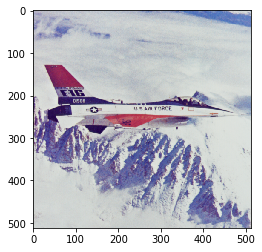

In [19]:
plt.imshow(np.transpose(y.detach().cpu().numpy(),[2,3,1,0])[:,:,:,0])

In [143]:
np.max(np.array(Image.open("5.png")))

234

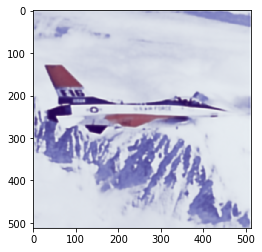

In [32]:
plt.imshow(avg_preds)

In [37]:
model = self2self(3,0.3)
img = util.load_np_image("image_crop.png")
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
p=0.3
p_mtx = np.random.uniform(size=img.shape)
mask = (p_mtx<p).astype(np.double)
img_input = img*mask
y = img - img_input

In [88]:
model.eval()
sum_preds = np.zeros((img.shape[0],img.shape[1],img.shape[2]))
for j in range(100):
    p_mtx = np.random.uniform(size=img.shape)
    mask = (p_mtx<p).astype(np.double)
    img_input = img*mask
    img_input_tensor = image_loader(img_input, device)
    
    output_test = model(img_input_tensor)
    sum_preds[:,:,:] += np.transpose(output_test.detach().cpu().numpy(),[2,3,1,0])[:,:,:,0]
avg_preds = np.squeeze(np.uint8(np.clip(sum_preds / NPred, 0, 1) * 255))
cv2.imwrite("images/Self2self-"+str(itr+1)+"l.png",avg_preds)
torch.save(model.state_dict(),'models/model-'+str(itr+1))

/home/yize/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


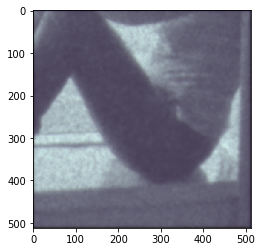

In [105]:
plt.imshow(np.transpose(output_test.detach().cpu().numpy(),[2,3,1,0])[:,:,:,0])